In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./GENEdata.csv")

In [3]:
df = df.drop("Unnamed: 0", axis = 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 16352 entries, gene_4773 to gene_14160
dtypes: float64(16335), int64(17)
memory usage: 99.9 MB


In [5]:
df.head()

,gene_4773,gene_8891,gene_15301,gene_4617,gene_5453,gene_11920,gene_742,gene_7964,gene_4618,gene_3921,...,gene_4828,gene_9309,gene_9321,gene_9323,gene_9350,gene_9744,gene_11130,gene_12489,gene_13860,gene_14160
0,0.833716,0.751905,0.916569,0.823836,0.867613,0.758256,0.055618,0.396663,0.721769,0.050259,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137670,0.294039,0.000000,0.049917,...,0,0,0,0,0,0,0,0,0,0
2,0.888350,0.844776,0.858810,0.821550,0.841350,0.934226,0.122805,0.081177,0.775723,0.067643,...,0,0,0,0,0,0,0,0,0,0
3,0.853238,0.875124,0.831437,0.939867,0.796857,0.878696,0.097675,0.200269,0.808865,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.188127,0.000000,0.000000,0.000000,0.093038,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.var()

gene_4773     0.169290
gene_8891     0.159168
gene_15301    0.151567
gene_4617     0.141604
gene_5453     0.132575
                ...   
gene_9744     0.001248
gene_11130    0.001248
gene_12489    0.001248
gene_13860    0.001248
gene_14160    0.001248
Length: 16352, dtype: float64

# Feature Extraction - Identifying Differentiating Dominant Features

### Variance Threshold Approach - Preserving Original Gene Features

In [11]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold to remove low-variance features
threshold = 0.12 #vary between 0.07 - 0.12 observe results
selector = VarianceThreshold(threshold=threshold)
data_high_variance = selector.fit_transform(df)

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)
selected_feature_names = df.columns[selected_features]

# Print the selected feature names
print("Selected Features:", selected_feature_names)

Selected Features: Index(['gene_4773', 'gene_8891', 'gene_15301', 'gene_4617', 'gene_5453',
       'gene_11920', 'gene_742'],
      dtype='object')


# Clustering

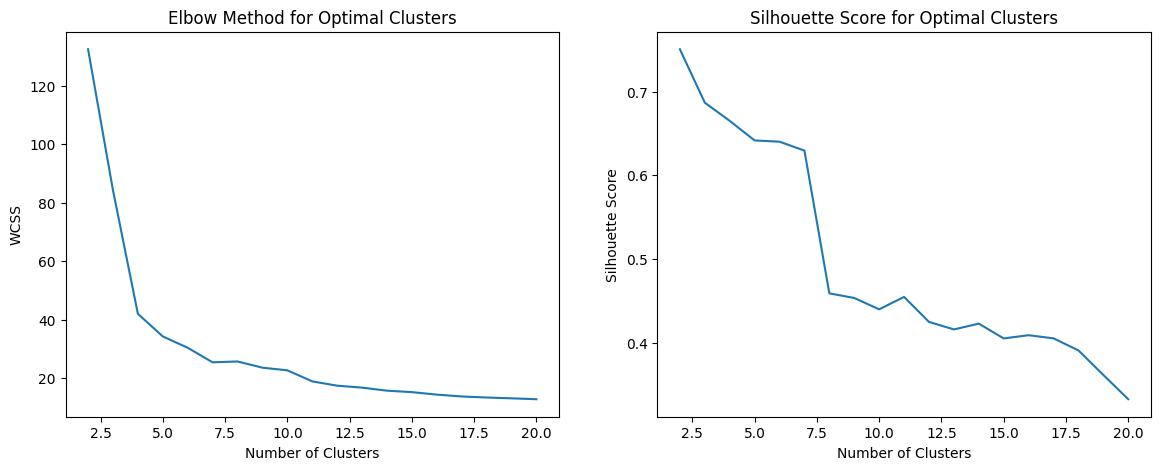

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Determine the optimal number of clusters
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 21)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_high_variance)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_high_variance, cluster_labels))

# Plot WCSS and silhouette scores to determine the optimal number of clusters
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

In [13]:
optimal_clusters = 4

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(data_high_variance)

# Add cluster labels to the original data for further analysis
df['cluster'] = clusters

In [14]:
df.cluster.unique()

array([1, 0, 3, 2])

## Visualizing Results

In [15]:
import numpy as np
from scipy import stats
import seaborn as sns

In [16]:
# Function to find top differentiating genes
def top_differentiating_genes(data, clusters, n_top=20):
    p_values = []
    for gene in range(data.shape[1]):
        f_value, p_value = stats.f_oneway(*[data[clusters == i, gene] for i in np.unique(clusters)])
        p_values.append(p_value)
    top_genes = np.argsort(p_values)[:n_top]
    return top_genes

top_genes = top_differentiating_genes(data_high_variance, clusters)

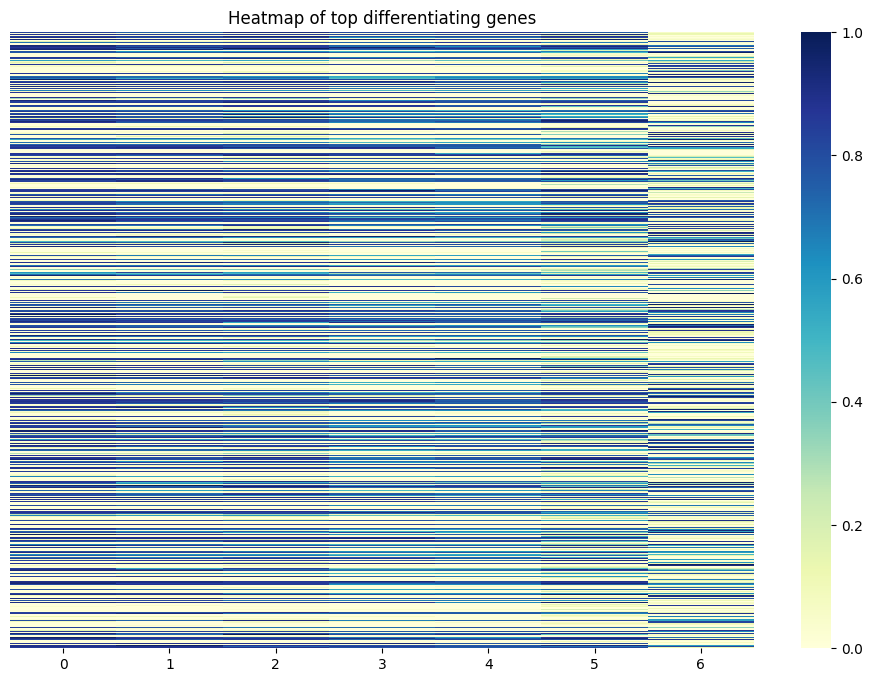

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_high_variance[:, top_genes], cmap='YlGnBu', yticklabels=False)
plt.title('Heatmap of top differentiating genes')
plt.show()

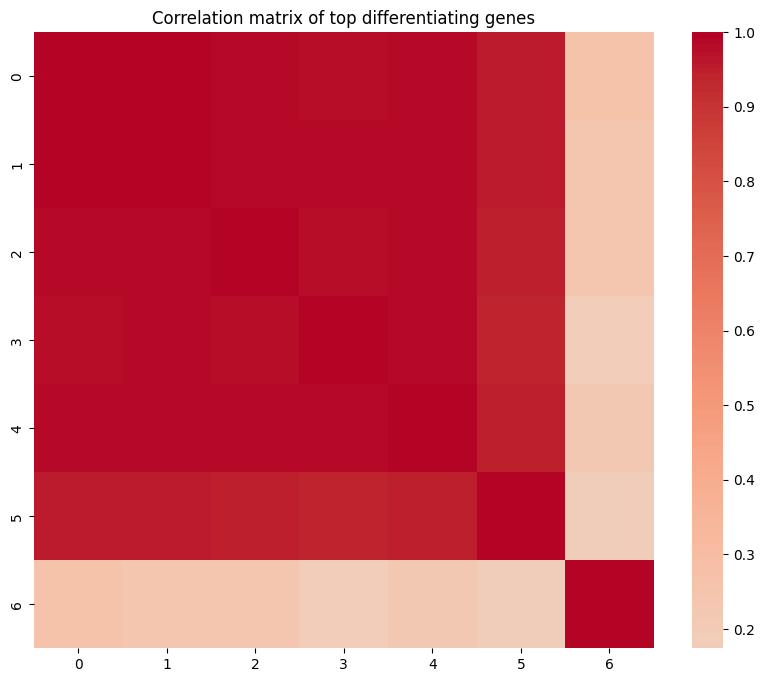

In [18]:
corr_matrix = np.corrcoef(data_high_variance[:, top_genes].T)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix of top differentiating genes')
plt.show()

# Identifying Dominant Features - For Each Cluster

* For each cluster, we can calculate the average expression of each gene.
* We can then compare these averages to the overall average expression across all clusters.
* The genes with the highest difference from the overall average could be considered the dominant or differentiating features for that cluster.

In [19]:
# Calculate overall mean expression for each gene
overall_mean = df.drop('cluster', axis=1).mean()

# Function to get top differentiating genes for a cluster
def get_top_genes(cluster_data, overall_mean, n=10):
    cluster_mean = cluster_data.mean()
    diff = cluster_mean - overall_mean
    top_over = diff.nlargest(n)
    top_under = diff.nsmallest(n)
    return pd.concat([top_over, top_under], keys=['Over-expressed', 'Under-expressed'])

In [20]:
# Get top differentiating genes for each cluster
top_genes_by_cluster = {}
for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster].drop('cluster', axis=1)
    top_genes_by_cluster[cluster] = get_top_genes(cluster_data, overall_mean)

In [21]:
for cluster, genes in top_genes_by_cluster.items():
    print(f"\nTop differentiating genes for Cluster {cluster}:")
    print(genes)


Top differentiating genes for Cluster 1:
Over-expressed   gene_8891     0.471701
                 gene_4617     0.470782
                 gene_4773     0.468044
                 gene_9175     0.463845
                 gene_15301    0.462572
                 gene_9176     0.445525
                 gene_5453     0.429971
                 gene_13976    0.429338
                 gene_11920    0.426820
                 gene_4618     0.423933
Under-expressed  gene_8024    -0.302422
                 gene_8031    -0.263404
                 gene_2831    -0.256508
                 gene_8032    -0.255278
                 gene_13217   -0.242849
                 gene_10266   -0.222356
                 gene_742     -0.220831
                 gene_6836    -0.216486
                 gene_2844    -0.212487
                 gene_9831    -0.209073
dtype: float64

Top differentiating genes for Cluster 0:
Over-expressed   gene_9652     0.251486
                 gene_15589    0.237269
                 gene

### Visualization of Clusters and their dominant features - Validating Clustering Results 

In [22]:
# 1. Prepare data for visualization
def prepare_data_for_viz(top_genes_by_cluster, df, n_top=5):
    all_top_genes = set()
    for genes in top_genes_by_cluster.values():
        all_top_genes.update(genes['Over-expressed'].index[:n_top])
        all_top_genes.update(genes['Under-expressed'].index[:n_top])
    
    viz_data = df[list(all_top_genes) + ['cluster']]
    return viz_data

viz_data = prepare_data_for_viz(top_genes_by_cluster, df)

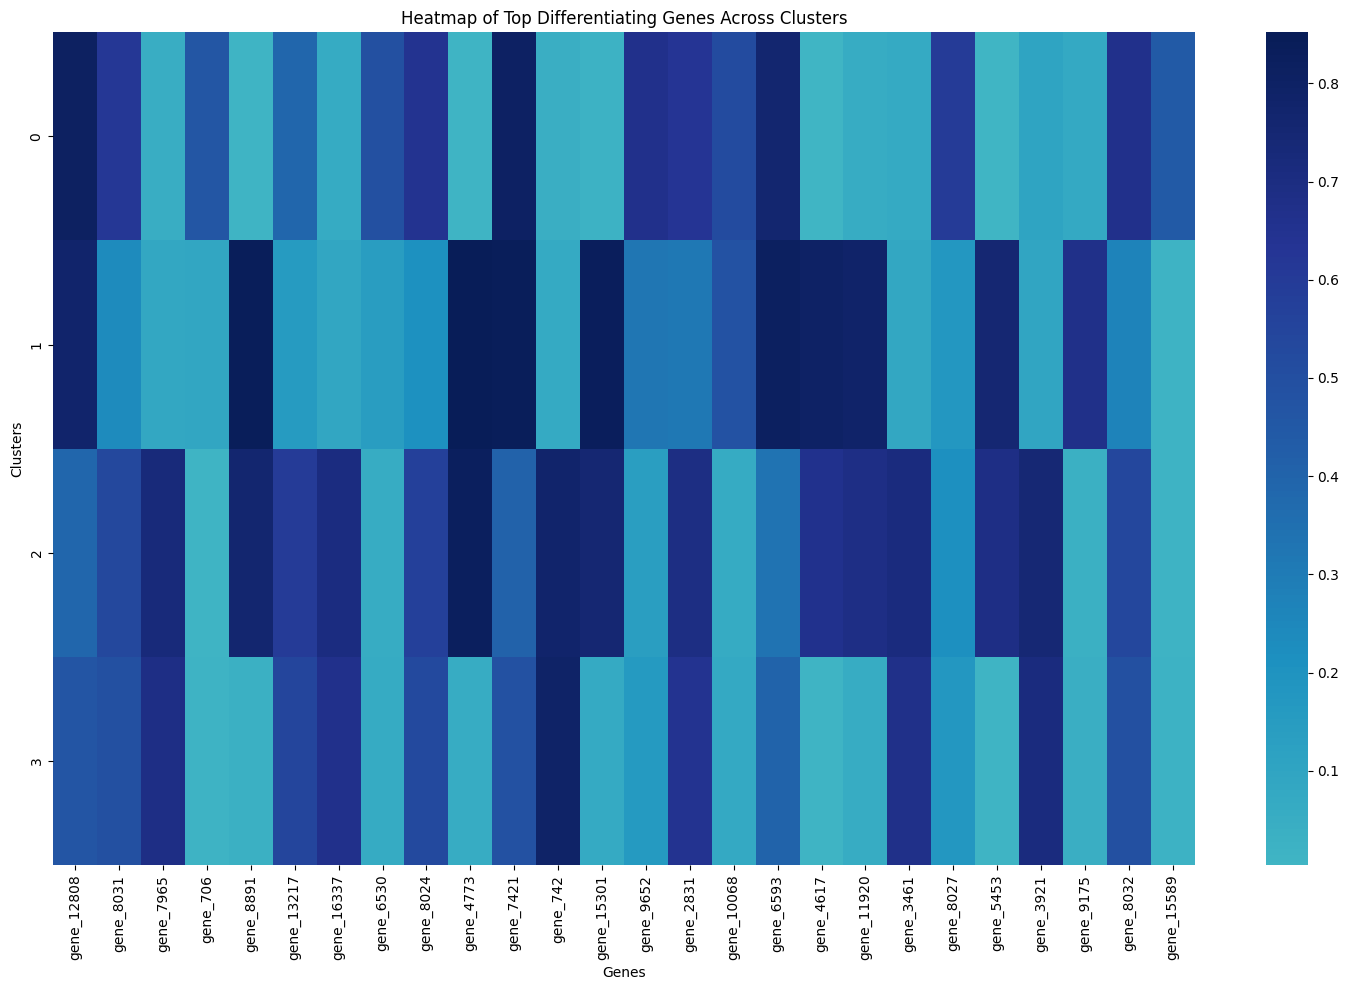

In [23]:
# 2. Create a heatmap
plt.figure(figsize=(15, 10))

# Prepare data for heatmap
heatmap_data = viz_data.groupby('cluster')[viz_data.columns[:-1]].mean()

# Create heatmap
sns.heatmap(heatmap_data, cmap='YlGnBu', center=0, annot=False)
plt.title('Heatmap of Top Differentiating Genes Across Clusters')
plt.xlabel('Genes')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

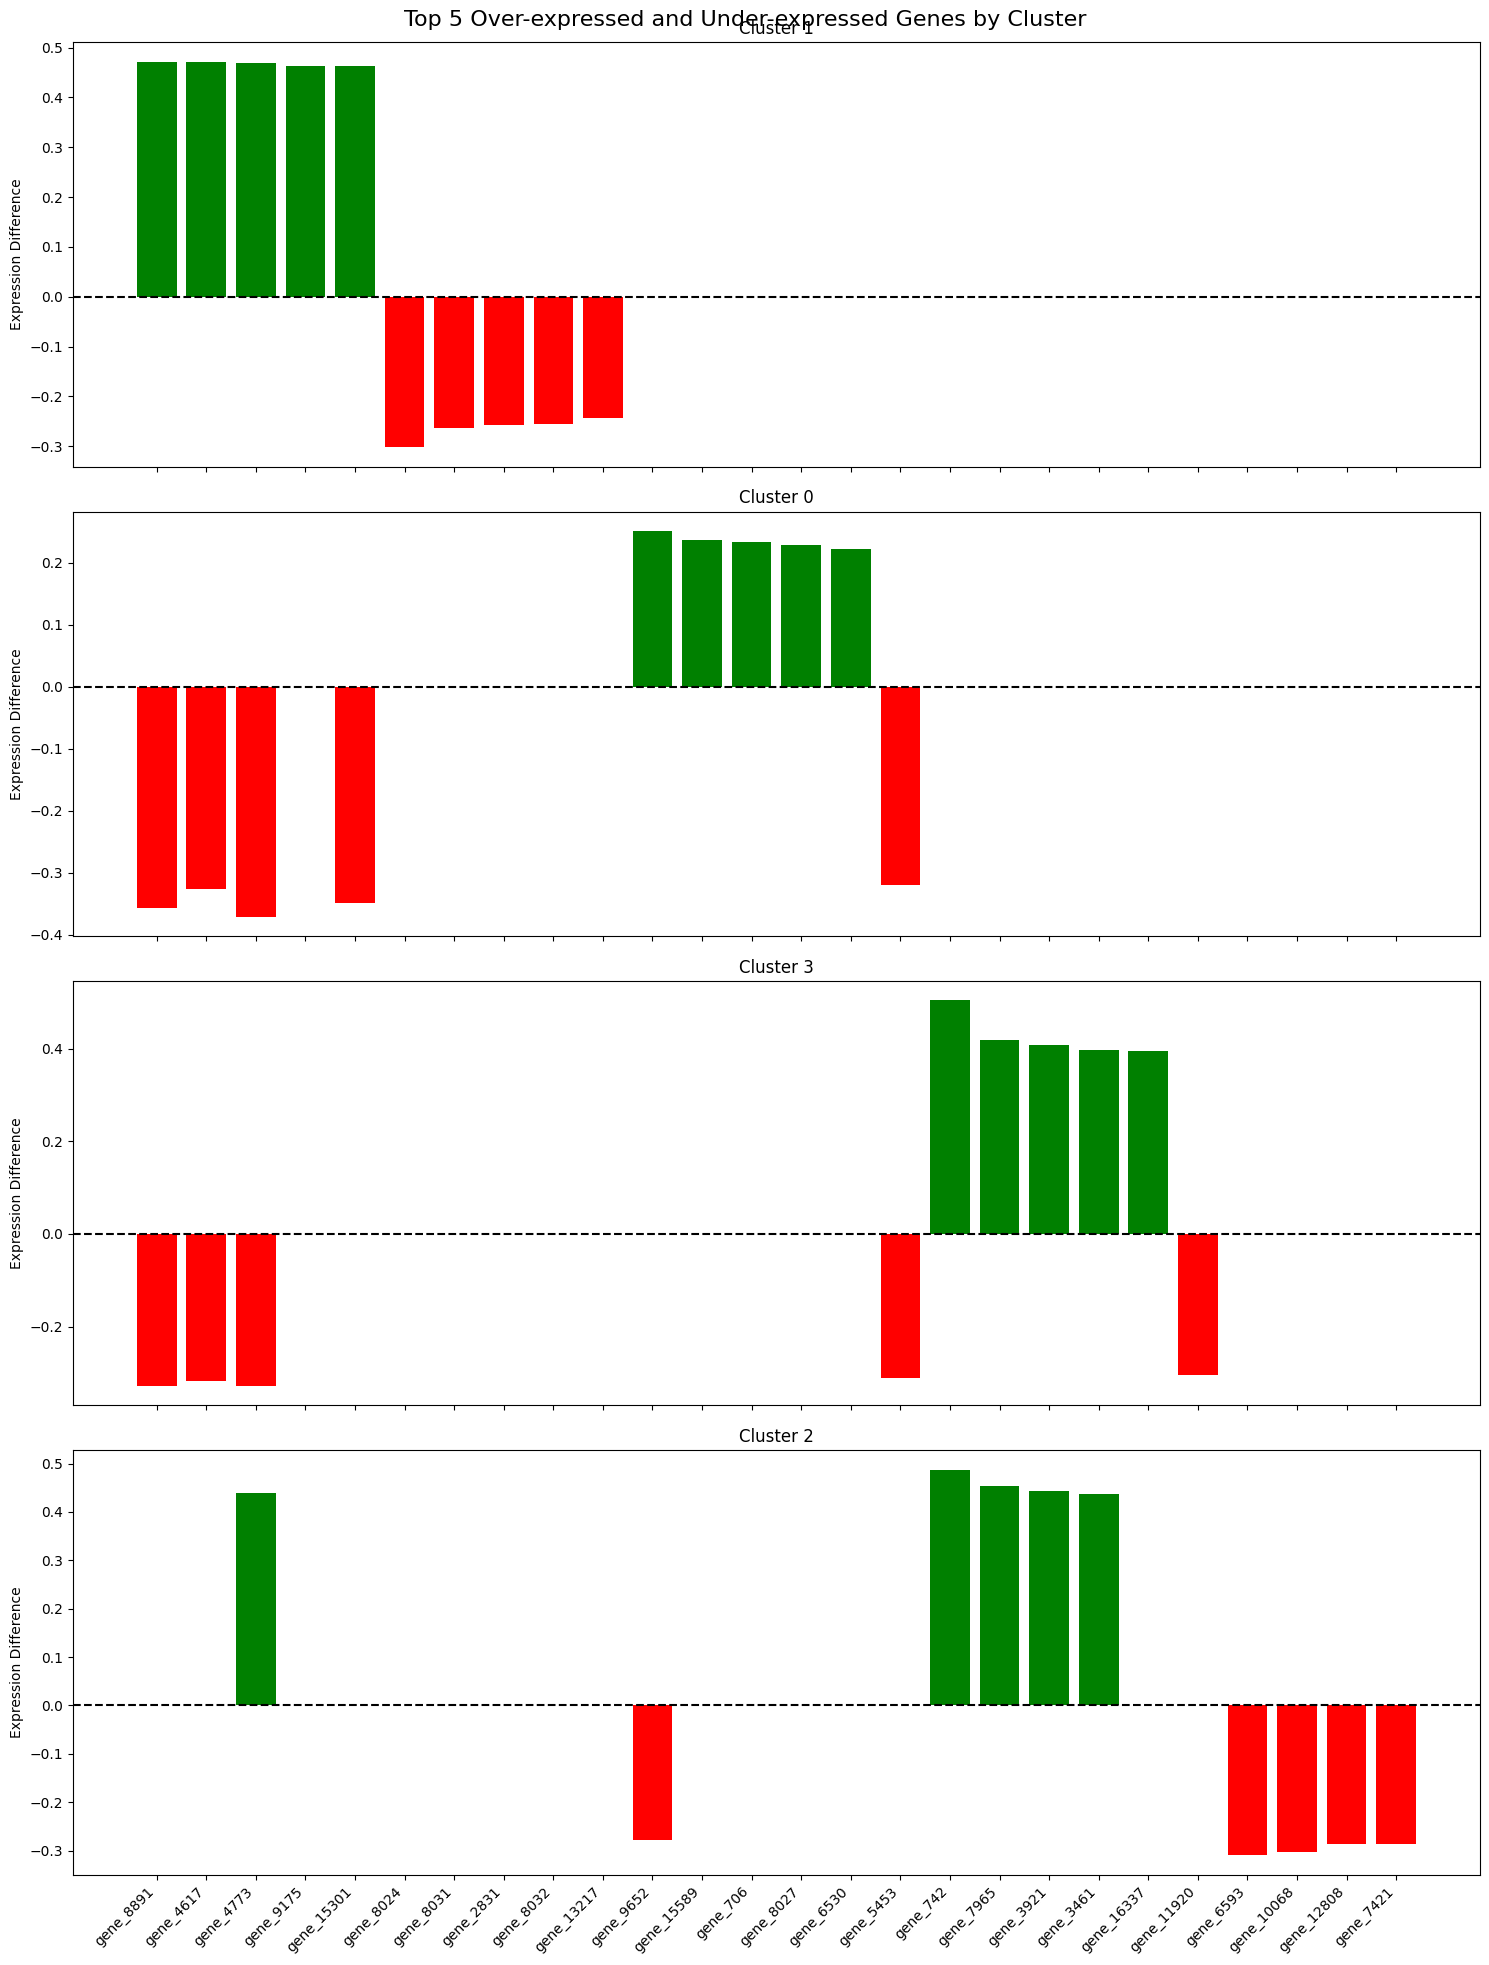

In [24]:
# 3. Create bar plots
n_clusters = len(top_genes_by_cluster)
fig, axes = plt.subplots(n_clusters, 1, figsize=(15, 5*n_clusters), sharex=True)
fig.suptitle('Top 5 Over-expressed and Under-expressed Genes by Cluster', fontsize=16)

for i, (cluster, genes) in enumerate(top_genes_by_cluster.items()):
    top_over = genes['Over-expressed'][:5]
    top_under = genes['Under-expressed'][:5]
    
    combined = pd.concat([top_over, top_under])
    colors = ['green']*5 + ['red']*5
    
    axes[i].bar(combined.index, combined.values, color=colors)
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_ylabel('Expression Difference')
    axes[i].axhline(y=0, color='k', linestyle='--')
    
    # Rotate x-axis labels for better readability
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import silhouette_score

cluster_labels = kmeans.labels_

# Compute silhouette score
silhouette_avg = silhouette_score(data_high_variance, cluster_labels)

print(f"Silhouette Score for Clustering: {silhouette_avg}")

Silhouette Score for Clustering: 0.6650405745325314


## Exploring Relationships 

Explore the relationships between the overall differentiating features (which we'll call **"Major Genes"**) and the top differentiating genes for each cluster (which we'll call **"minor genes of the cluster"**).

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [27]:
# 1. Identify Major Genes
major_genes = set(selected_feature_names)

# 2. Identify Minor Genes for each cluster
minor_genes_by_cluster = {}
for cluster, top_genes in top_genes_by_cluster.items():
    minor_genes = set(top_genes.index.get_level_values(1)) - major_genes
    minor_genes_by_cluster[cluster] = list(minor_genes)

In [28]:
major_genes_in_each_cluster = {}

# Loop through each cluster and find the intersection with major genes
for cluster, top_genes in top_genes_by_cluster.items():
    cluster_genes = set(top_genes.index.get_level_values(1))
    major_genes_in_cluster = major_genes.intersection(cluster_genes)
    major_genes_in_each_cluster[cluster] = list(major_genes_in_cluster)

for cluster, genes in major_genes_in_each_cluster.items():
    print(f"Cluster {cluster}: Major Genes: {genes}")

Cluster 1: Major Genes: ['gene_4617', 'gene_5453', 'gene_4773', 'gene_11920', 'gene_15301', 'gene_742', 'gene_8891']
Cluster 0: Major Genes: ['gene_4617', 'gene_5453', 'gene_4773', 'gene_11920', 'gene_15301', 'gene_742', 'gene_8891']
Cluster 3: Major Genes: ['gene_4617', 'gene_5453', 'gene_4773', 'gene_11920', 'gene_15301', 'gene_742', 'gene_8891']
Cluster 2: Major Genes: ['gene_742', 'gene_4773', 'gene_8891']


**Approach 1**
* Analyze and Visualize the Correlation Between "Major Genes" and "Minor Genes of the Cluster".

Analysis for Cluster 1


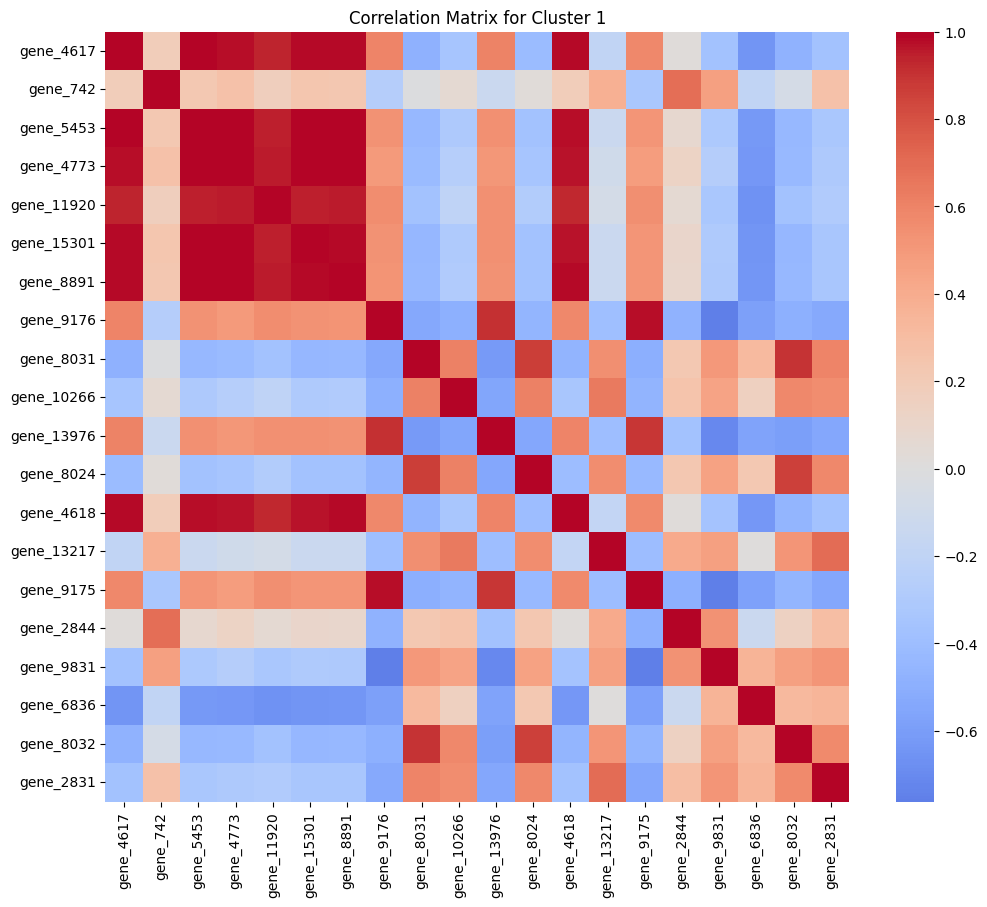

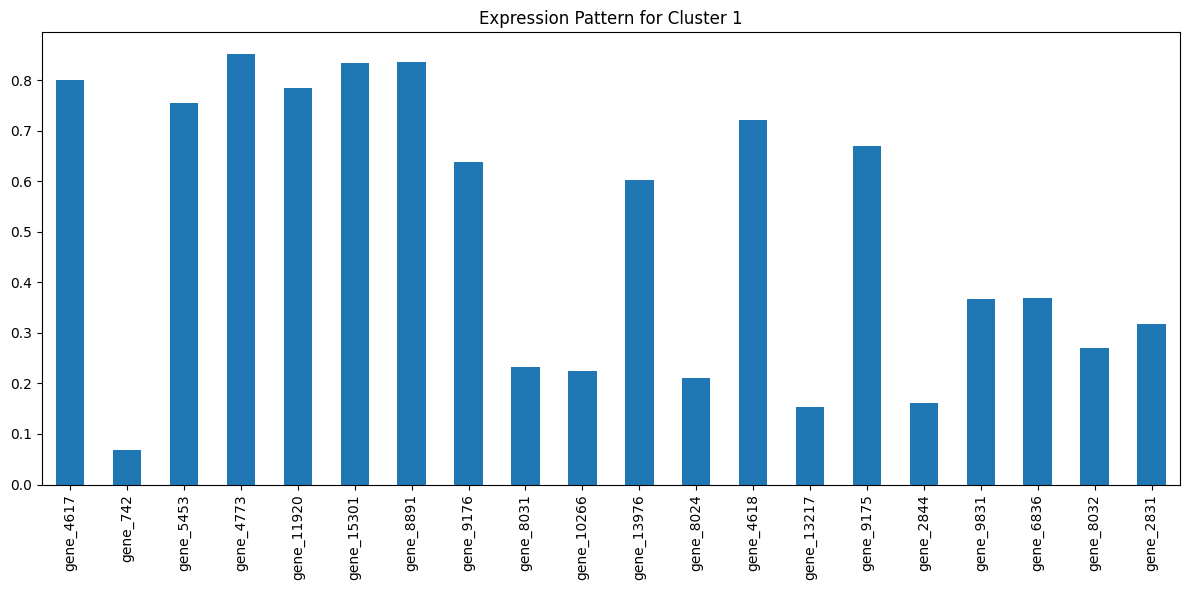

Highly correlated Major-Minor gene pairs:
gene_4617 - gene_4618: 0.984
gene_8891 - gene_4618: 0.982
gene_5453 - gene_4618: 0.975
gene_4773 - gene_4618: 0.967
gene_15301 - gene_4618: 0.966
gene_11920 - gene_4618: 0.928


Analysis for Cluster 0


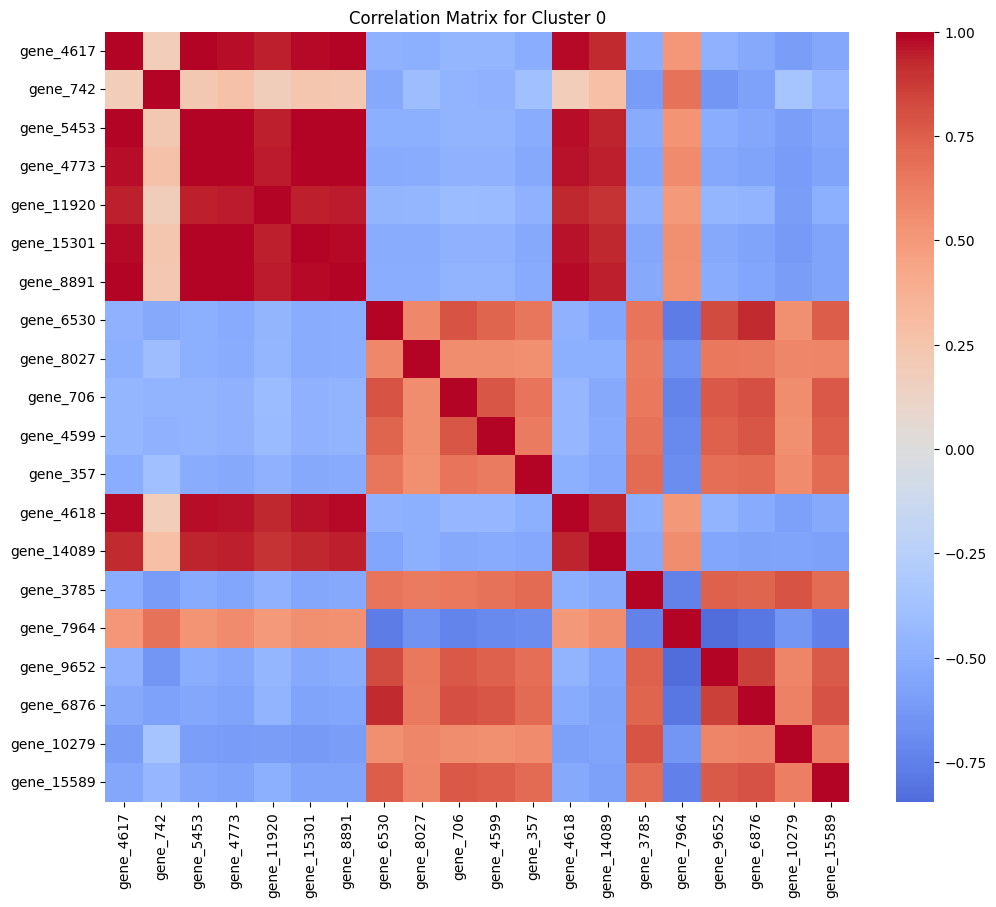

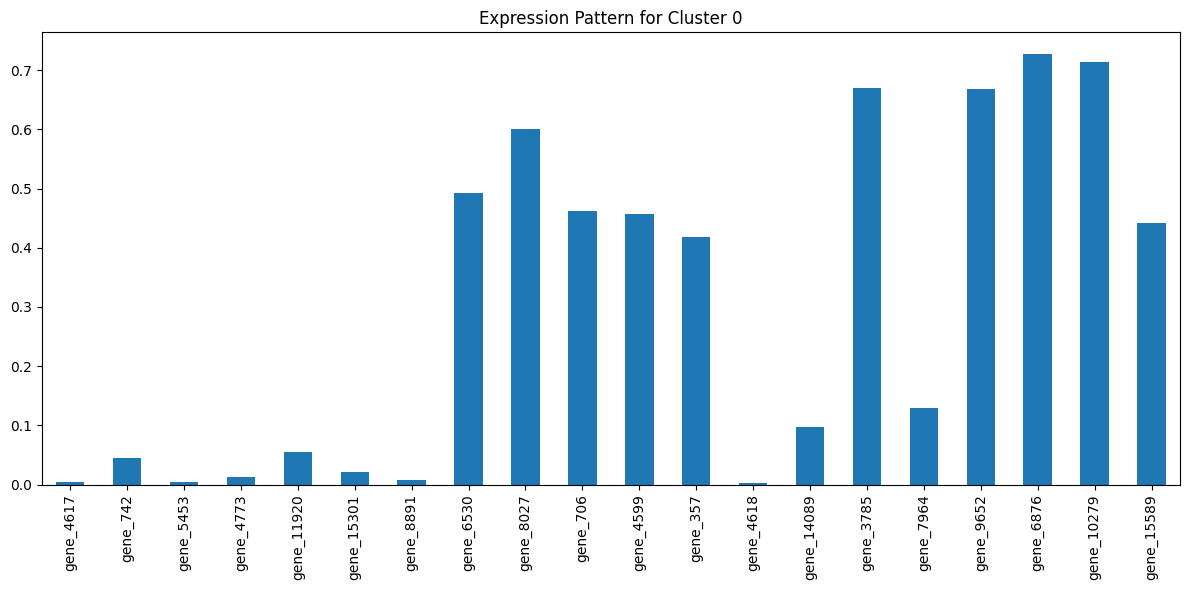

Highly correlated Major-Minor gene pairs:
gene_4617 - gene_4618: 0.984
gene_8891 - gene_4618: 0.982
gene_5453 - gene_4618: 0.975
gene_4773 - gene_4618: 0.967
gene_15301 - gene_4618: 0.966
gene_8891 - gene_14089: 0.950
gene_4773 - gene_14089: 0.947
gene_5453 - gene_14089: 0.936
gene_15301 - gene_14089: 0.933
gene_11920 - gene_4618: 0.928
gene_4617 - gene_14089: 0.927
gene_11920 - gene_14089: 0.893


Analysis for Cluster 3


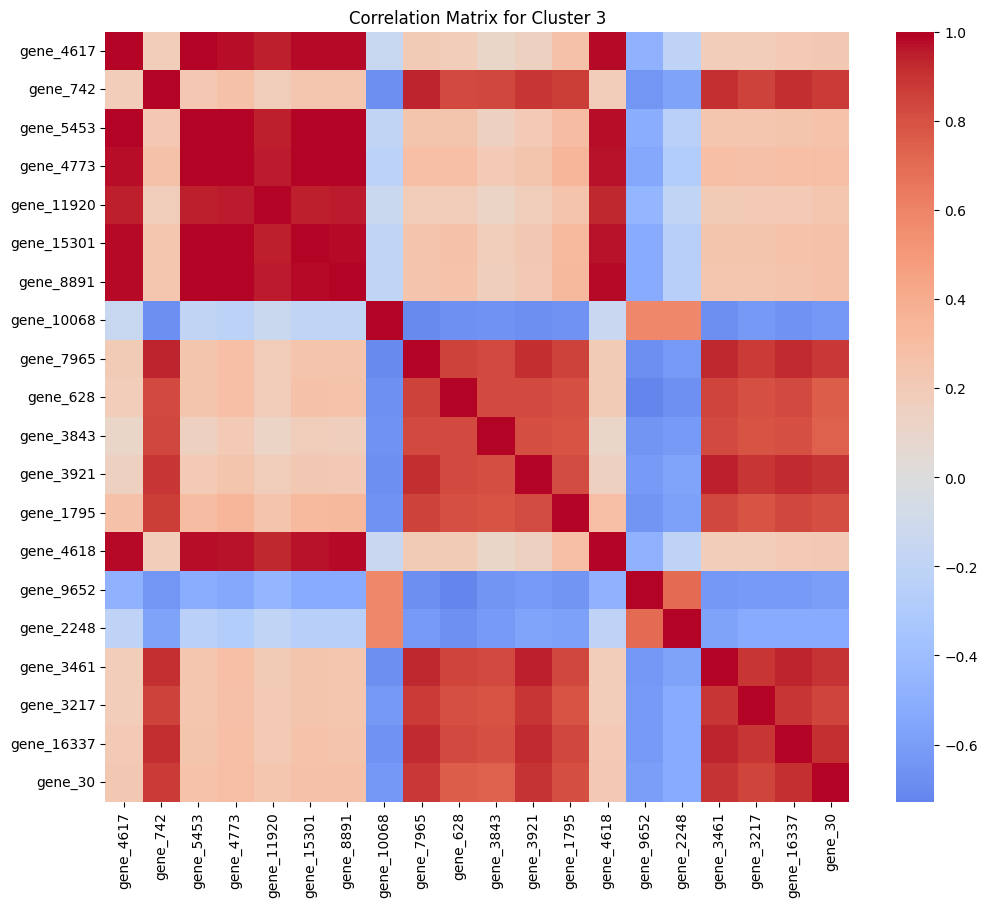

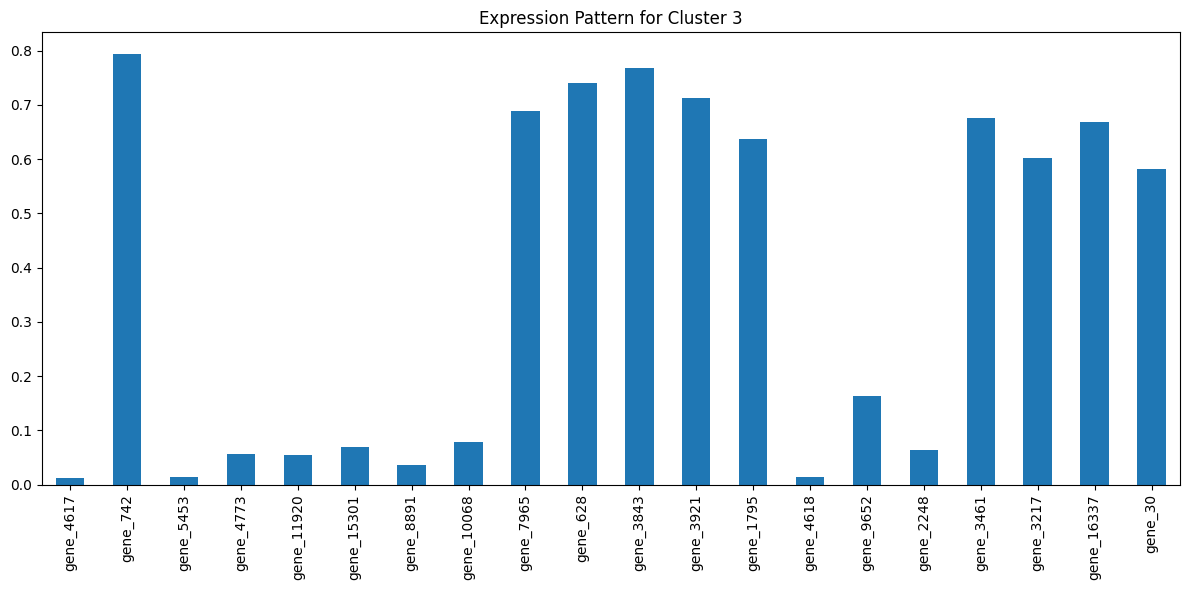

Highly correlated Major-Minor gene pairs:
gene_4617 - gene_4618: 0.984
gene_8891 - gene_4618: 0.982
gene_5453 - gene_4618: 0.975
gene_4773 - gene_4618: 0.967
gene_15301 - gene_4618: 0.966
gene_742 - gene_7965: 0.937
gene_11920 - gene_4618: 0.928
gene_742 - gene_16337: 0.916
gene_742 - gene_3461: 0.911
gene_742 - gene_3921: 0.890
gene_742 - gene_30: 0.878
gene_742 - gene_1795: 0.870
gene_742 - gene_3217: 0.857
gene_742 - gene_3843: 0.835
gene_742 - gene_628: 0.827


Analysis for Cluster 2


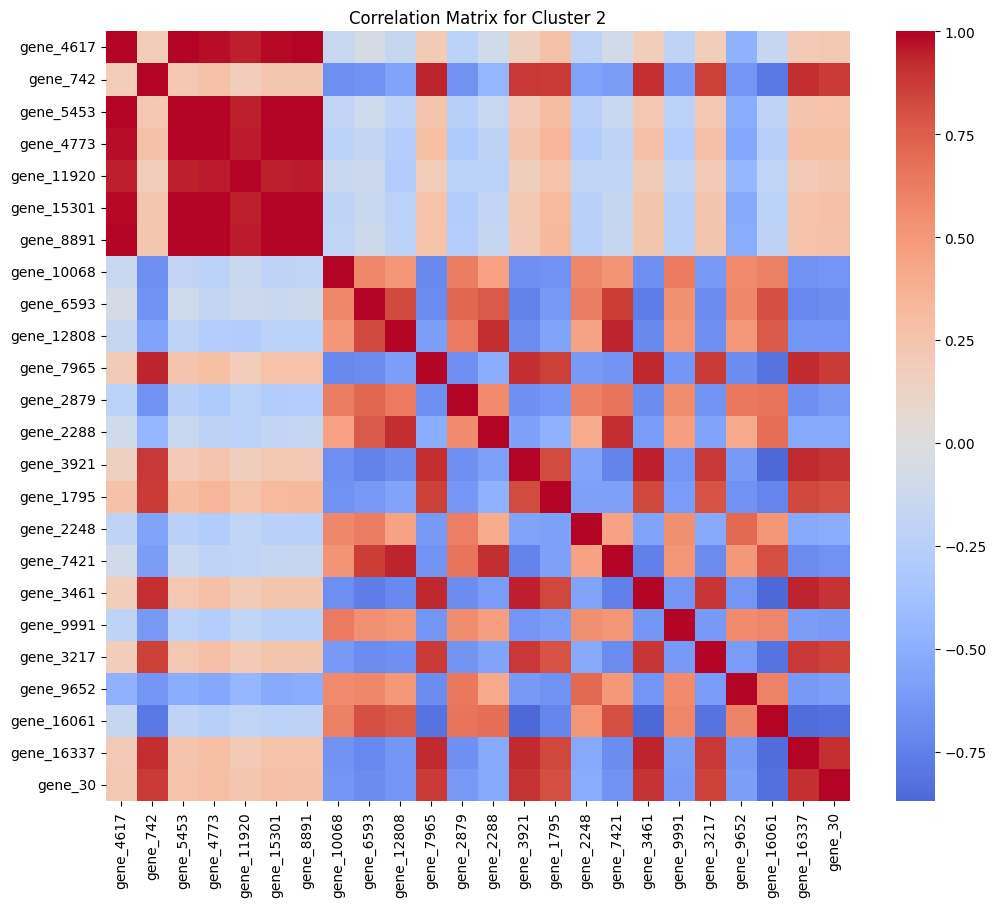

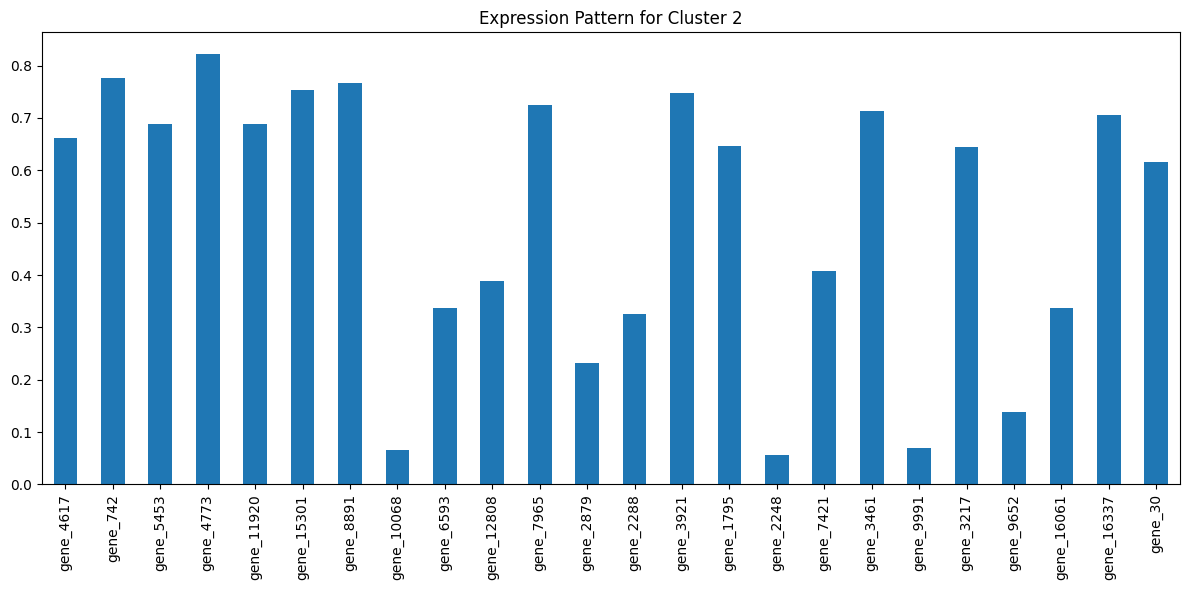

Highly correlated Major-Minor gene pairs:
gene_742 - gene_7965: 0.937
gene_742 - gene_16337: 0.916
gene_742 - gene_3461: 0.911
gene_742 - gene_3921: 0.890
gene_742 - gene_30: 0.878
gene_742 - gene_1795: 0.870
gene_742 - gene_3217: 0.857
gene_742 - gene_16061: -0.785




In [29]:
# 3. Analyze relationships
# 3.1 Correlation analysis
def correlation_analysis(df, major_genes, minor_genes):
    genes = list(major_genes) + minor_genes
    corr_matrix = df[genes].corr()
    return corr_matrix

# 3.2 Expression pattern comparison
def expression_pattern(df, genes, cluster):
    return df[df['cluster'] == cluster][genes].mean()

# Perform analysis for each cluster
for cluster in df['cluster'].unique():
    print(f"Analysis for Cluster {cluster}")
    
    # Correlation analysis
    corr_matrix = correlation_analysis(df, major_genes, minor_genes_by_cluster[cluster])
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title(f"Correlation Matrix for Cluster {cluster}")
    # plt.savefig(f"correlation_matrix_cluster_{cluster}.png")
    plt.show()
    
    # Expression pattern comparison
    expr_pattern = expression_pattern(df, list(major_genes) + minor_genes_by_cluster[cluster], cluster)
    
    # Visualize expression pattern
    plt.figure(figsize=(12, 6))
    expr_pattern.plot(kind='bar')
    plt.title(f"Expression Pattern for Cluster {cluster}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig(f"expression_pattern_cluster_{cluster}.png")
    plt.show()
    
    # Additional analysis: Find highly correlated gene pairs
    high_corr_pairs = []
    for major_gene in major_genes:
        for minor_gene in minor_genes_by_cluster[cluster]:
            corr, _ = pearsonr(df[major_gene], df[minor_gene])
            if abs(corr) > 0.7:  # You can adjust this threshold
                high_corr_pairs.append((major_gene, minor_gene, corr))
    
    print("Highly correlated Major-Minor gene pairs:")
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
    
    print("\n")

Analysis for Cluster 1


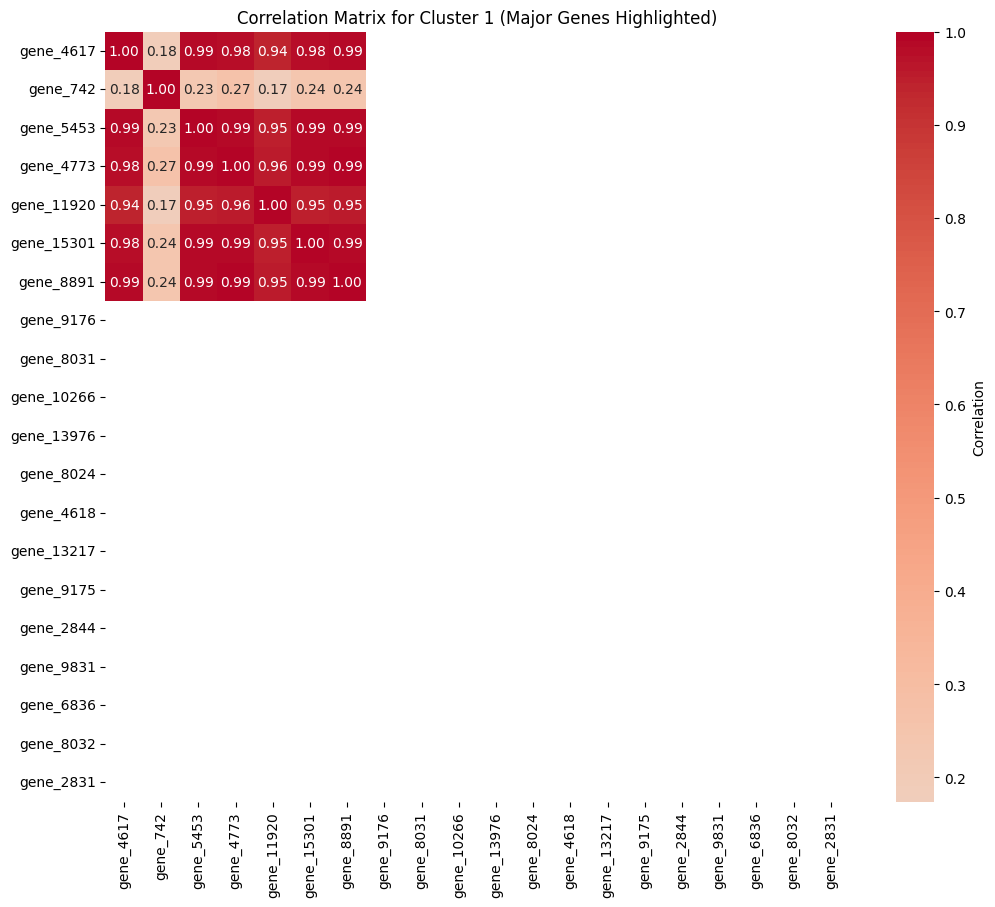

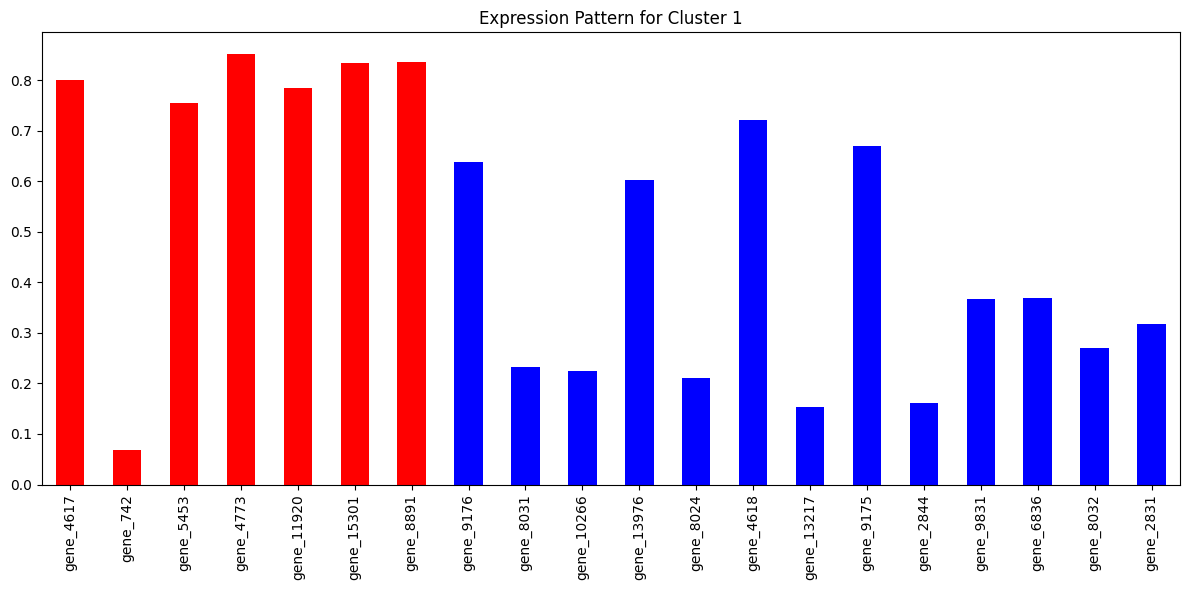

Highly correlated Major-Minor gene pairs:
gene_4617 - gene_4618: 0.984
gene_8891 - gene_4618: 0.982
gene_5453 - gene_4618: 0.975
gene_4773 - gene_4618: 0.967
gene_15301 - gene_4618: 0.966
gene_11920 - gene_4618: 0.928


Analysis for Cluster 0


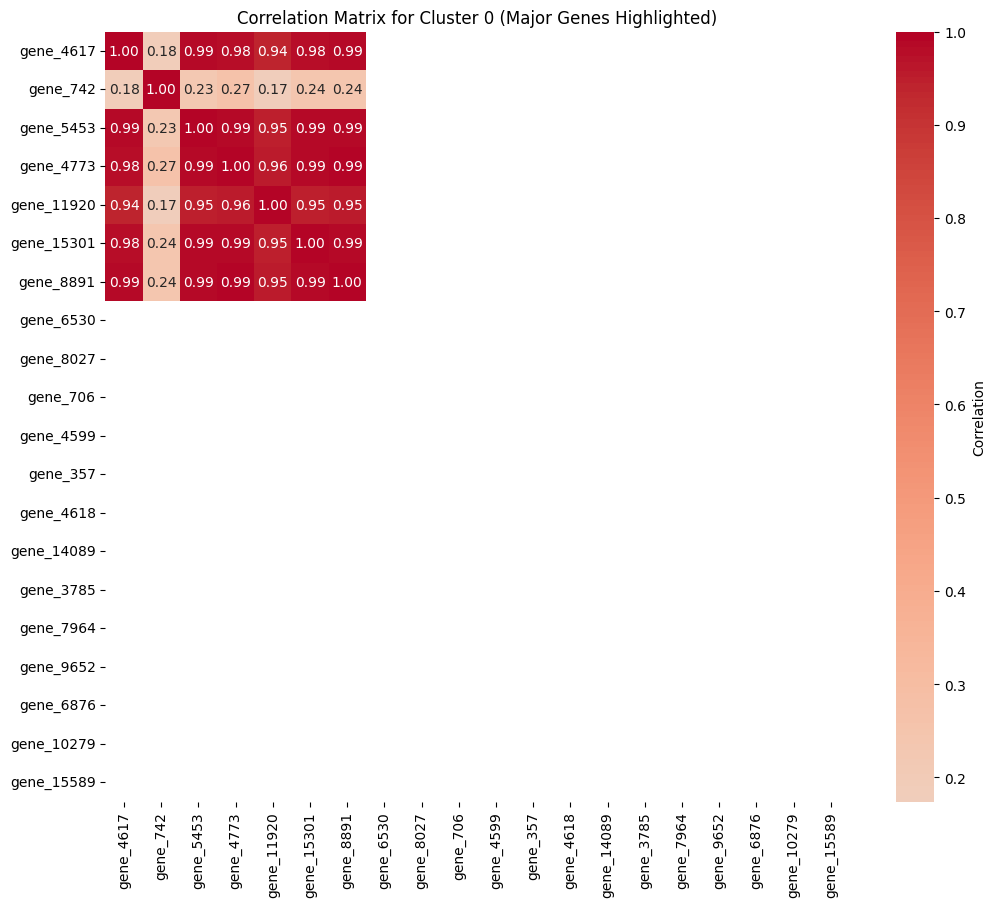

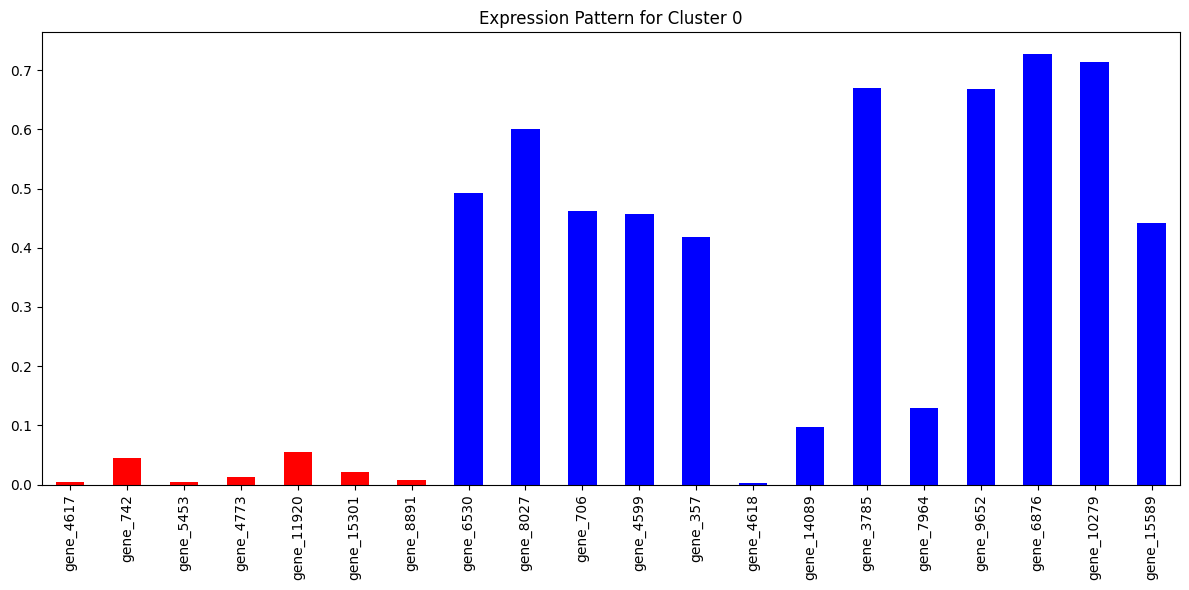

Highly correlated Major-Minor gene pairs:
gene_4617 - gene_4618: 0.984
gene_8891 - gene_4618: 0.982
gene_5453 - gene_4618: 0.975
gene_4773 - gene_4618: 0.967
gene_15301 - gene_4618: 0.966
gene_8891 - gene_14089: 0.950
gene_4773 - gene_14089: 0.947
gene_5453 - gene_14089: 0.936
gene_15301 - gene_14089: 0.933
gene_11920 - gene_4618: 0.928
gene_4617 - gene_14089: 0.927
gene_11920 - gene_14089: 0.893


Analysis for Cluster 3


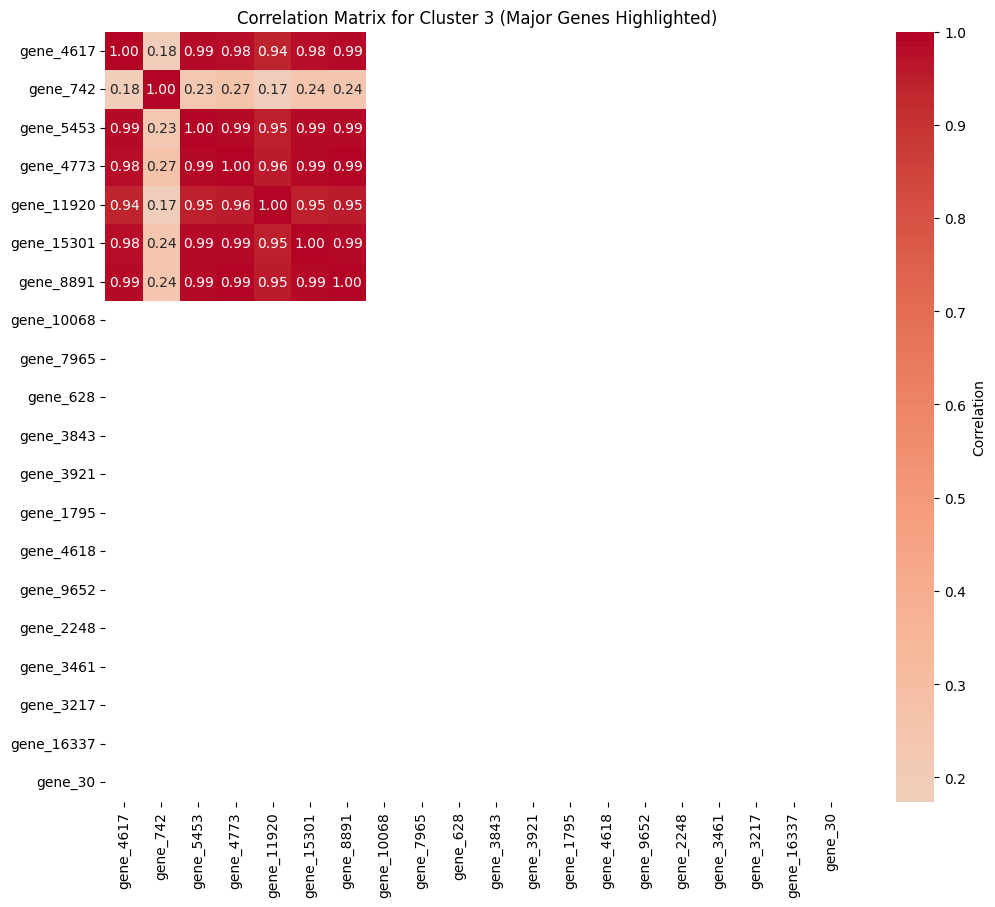

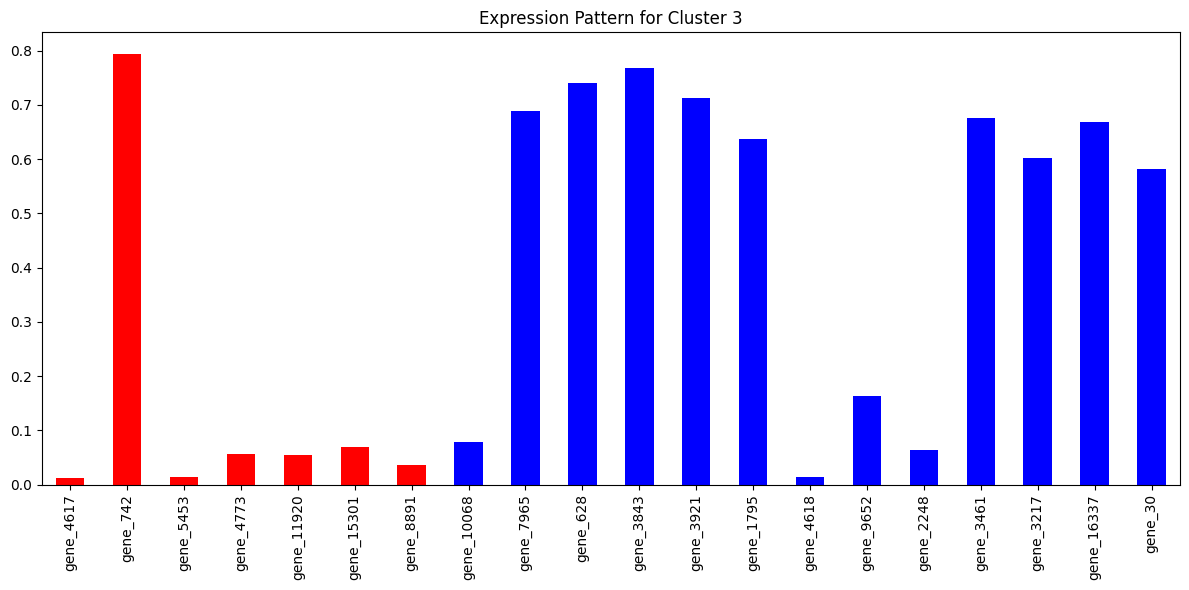

Highly correlated Major-Minor gene pairs:
gene_4617 - gene_4618: 0.984
gene_8891 - gene_4618: 0.982
gene_5453 - gene_4618: 0.975
gene_4773 - gene_4618: 0.967
gene_15301 - gene_4618: 0.966
gene_742 - gene_7965: 0.937
gene_11920 - gene_4618: 0.928
gene_742 - gene_16337: 0.916
gene_742 - gene_3461: 0.911
gene_742 - gene_3921: 0.890
gene_742 - gene_30: 0.878
gene_742 - gene_1795: 0.870
gene_742 - gene_3217: 0.857
gene_742 - gene_3843: 0.835
gene_742 - gene_628: 0.827


Analysis for Cluster 2


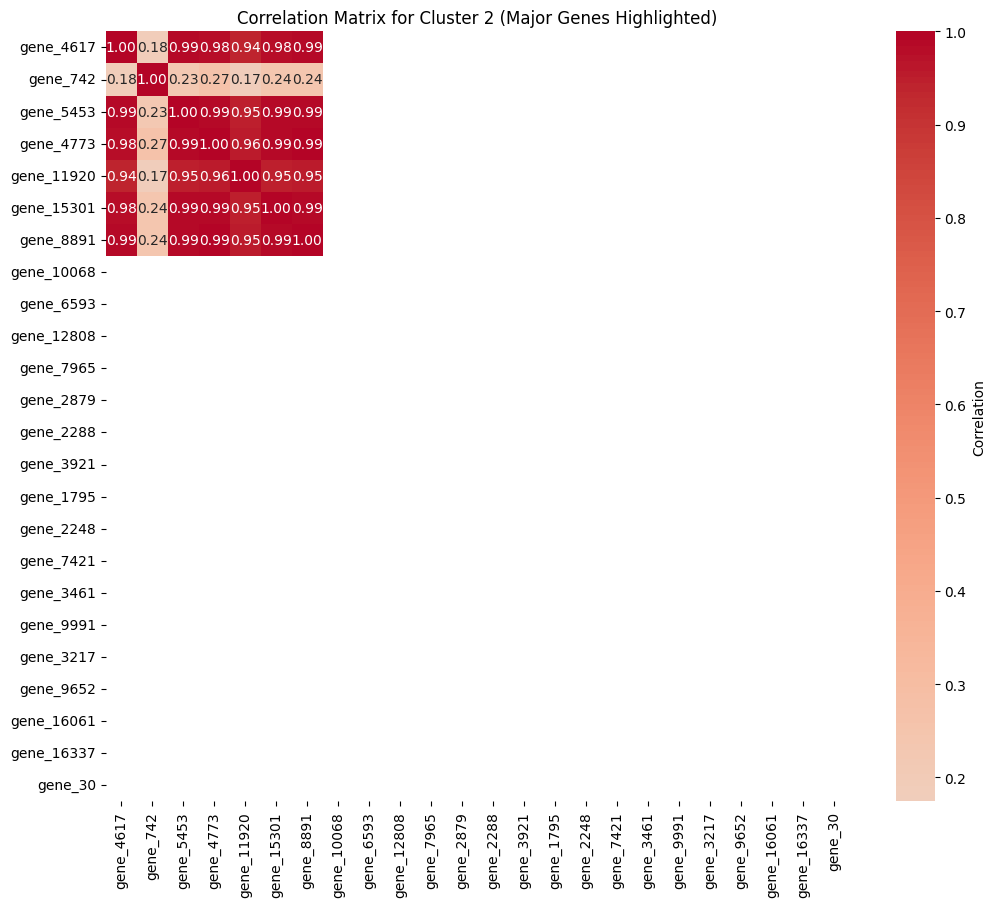

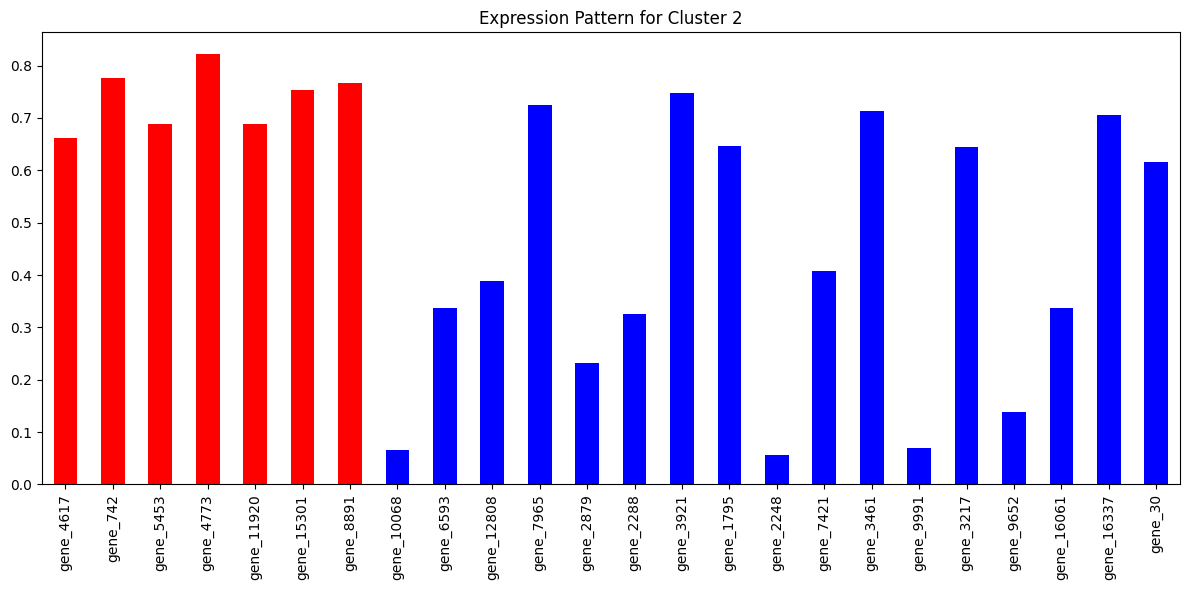

Highly correlated Major-Minor gene pairs:
gene_742 - gene_7965: 0.937
gene_742 - gene_16337: 0.916
gene_742 - gene_3461: 0.911
gene_742 - gene_3921: 0.890
gene_742 - gene_30: 0.878
gene_742 - gene_1795: 0.870
gene_742 - gene_3217: 0.857
gene_742 - gene_16061: -0.785




In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Ensure the necessary functions are defined
# correlation_analysis and expression_pattern should be defined elsewhere in your code

# Perform analysis for each cluster
for cluster in df['cluster'].unique():
    print(f"Analysis for Cluster {cluster}")
    
    # Correlation analysis
    corr_matrix = correlation_analysis(df, major_genes, minor_genes_by_cluster[cluster])
    
    # Create a mask to differentiate major and minor genes
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.ix_(corr_matrix.index.isin(major_genes), corr_matrix.columns.isin(major_genes))] = True
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f",
                mask=~mask, cbar_kws={'label': 'Correlation'})
    plt.title(f"Correlation Matrix for Cluster {cluster} (Major Genes Highlighted)")
    # plt.savefig(f"correlation_matrix_cluster_{cluster}.png")
    plt.show()
    
    # Expression pattern comparison
    expr_pattern = expression_pattern(df, list(major_genes) + minor_genes_by_cluster[cluster], cluster)
    
    # Color code the expression patterns
    colors = ['red' if gene in major_genes else 'blue' for gene in expr_pattern.index]
    
    # Visualize expression pattern
    plt.figure(figsize=(12, 6))
    expr_pattern.plot(kind='bar', color=colors, legend=False)
    plt.title(f"Expression Pattern for Cluster {cluster}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig(f"expression_pattern_cluster_{cluster}.png")
    plt.show()
    
    # Additional analysis: Find highly correlated gene pairs
    high_corr_pairs = []
    for major_gene in major_genes:
        for minor_gene in minor_genes_by_cluster[cluster]:
            corr, _ = pearsonr(df[major_gene], df[minor_gene])
            if abs(corr) > 0.7:  # You can adjust this threshold
                high_corr_pairs.append((major_gene, minor_gene, corr))
    
    print("Highly correlated Major-Minor gene pairs:")
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
    
    print("\n")


**Approach 2 - using Neural Nets ("Major Genes" - "Minor Genes of the Cluster")**

- Use "Major Genes" as input neurons.
- Use "Minor Genes of the Cluster" as hidden layers.
- The output layer should predict the cluster.
- Train the neural network and analyze the weights to understand the relationship between dominant and minor features.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [32]:
def build_and_train_nn(X, y, input_genes, hidden_genes, cluster):
    # Preprocess the data
    X = X[input_genes + hidden_genes]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_encoded = to_categorical(y == cluster)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

    # Build the model with flexible layer sizes
    model = Sequential([
        Dense(len(input_genes), activation='relu', input_shape=(X.shape[1],), 
              name=f'input_layer_cluster_{cluster}'),
        Dense(len(hidden_genes), activation='relu', name=f'hidden_layer_cluster_{cluster}'),
        Dense(2, activation='softmax', name=f'output_layer_cluster_{cluster}')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")

    return model, history

In [33]:
def analyze_weights(model, input_genes, hidden_genes):
    input_to_hidden = model.layers[0].get_weights()[0]
    hidden_to_output = model.layers[1].get_weights()[0]

    # Analyze input to hidden weights
    input_hidden_importance = np.abs(input_to_hidden).mean(axis=1)
    
    # Ensure we only use the correct number of values for input
    n_input = min(len(input_genes), len(input_hidden_importance))
    input_importance = pd.Series(input_hidden_importance[:n_input], index=input_genes[:n_input])
    
    # Analyze hidden to output weights
    hidden_output_importance = np.abs(hidden_to_output).mean(axis=1)
    
    # Ensure we only use the correct number of values for hidden
    n_hidden = min(len(hidden_genes), len(hidden_output_importance))
    hidden_importance = pd.Series(hidden_output_importance[:n_hidden], index=hidden_genes[:n_hidden])

    print(f"Input layer shape: {input_to_hidden.shape}")
    print(f"Hidden layer shape: {hidden_to_output.shape}")
    print(f"Number of input genes: {len(input_genes)}")
    print(f"Number of hidden genes: {len(hidden_genes)}")

    return input_importance, hidden_importance


Analysis for Cluster 1
Number of input genes: 7
Number of hidden genes: 13


C:\Users\MSI 1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy for Cluster 1: 0.9752
Input layer shape: (20, 7)
Hidden layer shape: (7, 13)
Number of input genes: 7
Number of hidden genes: 13

Top 5 most important input genes:
gene_742      0.478551
gene_4773     0.427404
gene_4617     0.364057
gene_11920    0.358886
gene_15301    0.265530
dtype: float32

Top 5 most important hidden (minor) genes:
gene_13217    0.376851
gene_9176     0.365400
gene_4618     0.357425
gene_10266    0.356577
gene_8031     0.352923
dtype: float32


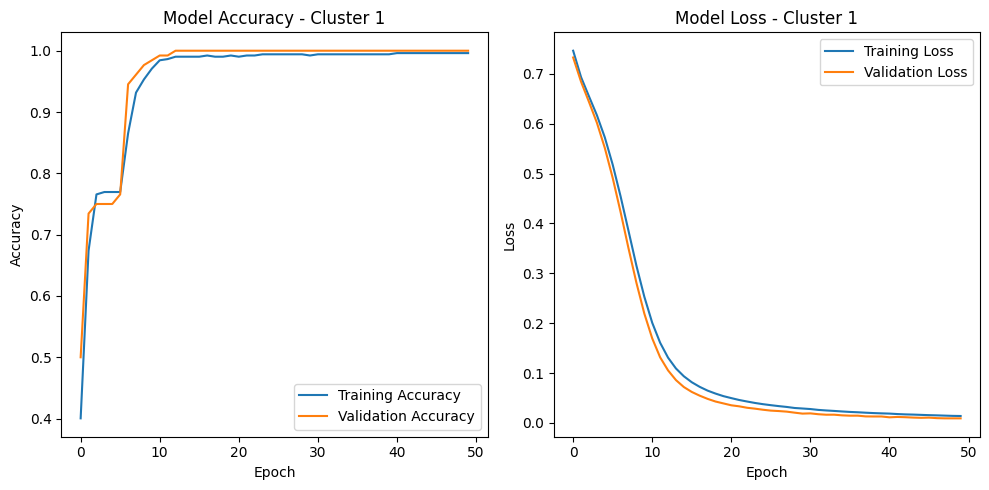


Analysis for Cluster 0
Number of input genes: 7
Number of hidden genes: 13


C:\Users\MSI 1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy for Cluster 0: 0.9752
Input layer shape: (20, 7)
Hidden layer shape: (7, 13)
Number of input genes: 7
Number of hidden genes: 13

Top 5 most important input genes:
gene_742      0.540076
gene_4617     0.288893
gene_15301    0.271109
gene_4773     0.258994
gene_8891     0.250277
dtype: float32

Top 5 most important hidden (minor) genes:
gene_6530     0.394433
gene_14089    0.389691
gene_4618     0.338726
gene_706      0.299949
gene_8027     0.271373
dtype: float32


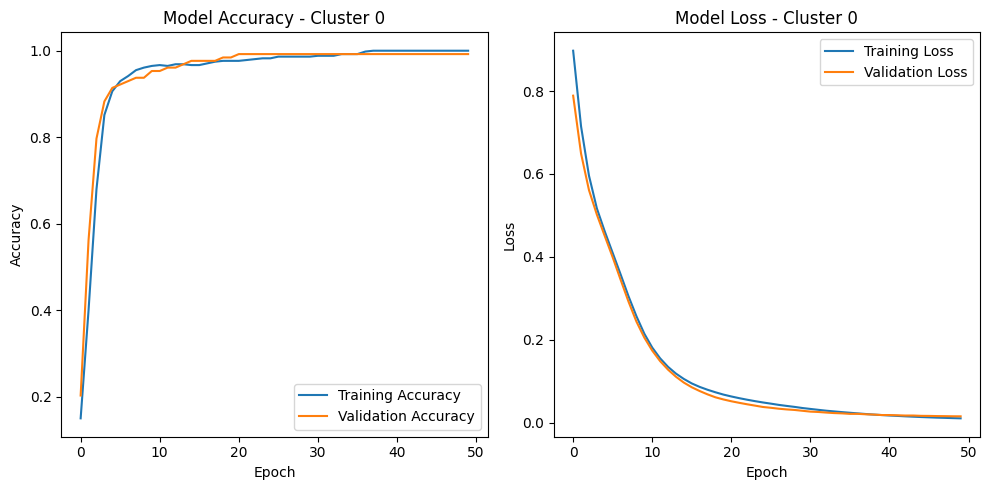


Analysis for Cluster 3
Number of input genes: 7
Number of hidden genes: 13


C:\Users\MSI 1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy for Cluster 3: 0.9752
Input layer shape: (20, 7)
Hidden layer shape: (7, 13)
Number of input genes: 7
Number of hidden genes: 13

Top 5 most important input genes:
gene_742      0.335188
gene_4773     0.284400
gene_4617     0.284387
gene_11920    0.260017
gene_15301    0.252084
dtype: float32

Top 5 most important hidden (minor) genes:
gene_3921     0.473327
gene_4618     0.472898
gene_3843     0.337527
gene_7965     0.300850
gene_10068    0.285281
dtype: float32


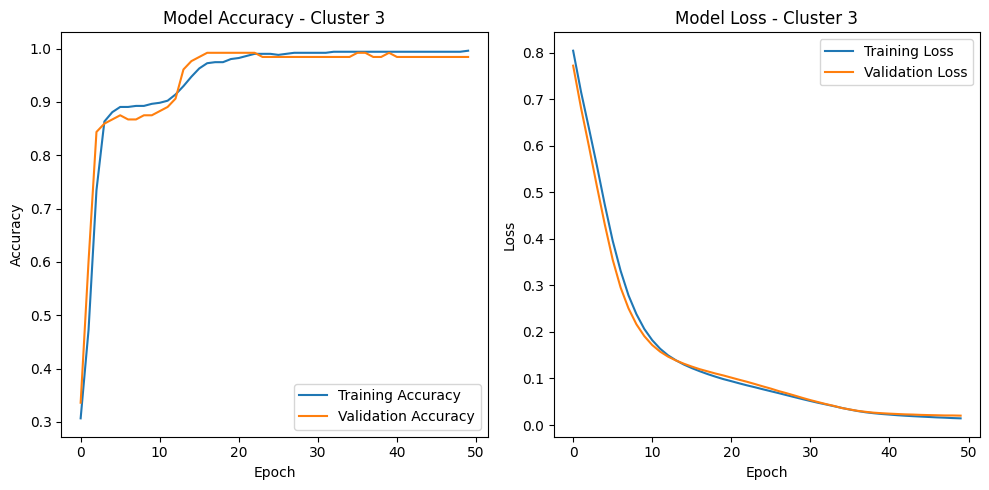


Analysis for Cluster 2
Number of input genes: 7
Number of hidden genes: 17


C:\Users\MSI 1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy for Cluster 2: 0.9752
Input layer shape: (24, 7)
Hidden layer shape: (7, 17)
Number of input genes: 7
Number of hidden genes: 17

Top 5 most important input genes:
gene_8891     0.435360
gene_742      0.388017
gene_15301    0.349144
gene_5453     0.281512
gene_11920    0.258590
dtype: float32

Top 5 most important hidden (minor) genes:
gene_2288     0.458937
gene_3921     0.373714
gene_7965     0.305321
gene_6593     0.284875
gene_12808    0.271722
dtype: float32


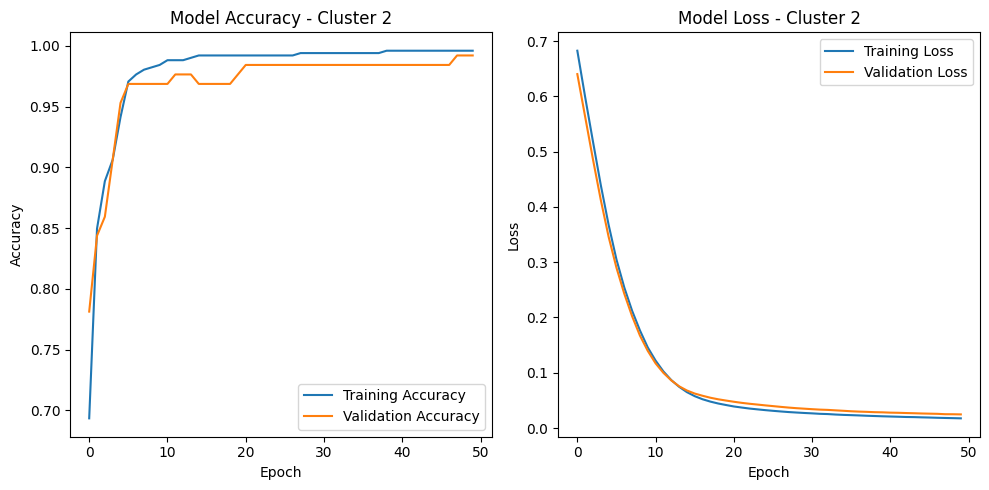

In [34]:
# Perform analysis for each cluster
for cluster in df['cluster'].unique():
    print(f"\nAnalysis for Cluster {cluster}")
    
    X = df.drop('cluster', axis=1)
    y = df['cluster']
    
    cluster_input_genes = list(major_genes)
    cluster_hidden_genes = minor_genes_by_cluster[cluster]

    print(f"Number of input genes: {len(cluster_input_genes)}")
    print(f"Number of hidden genes: {len(cluster_hidden_genes)}")
    
    model, history = build_and_train_nn(X, y, cluster_input_genes, cluster_hidden_genes, cluster)
    
    input_importance, hidden_importance = analyze_weights(model, cluster_input_genes, cluster_hidden_genes)
    
    print("\nTop 5 most important input genes:")
    print(input_importance.nlargest(min(5, len(input_importance))))
    
    print("\nTop 5 most important hidden (minor) genes:")
    print(hidden_importance.nlargest(min(5, len(hidden_importance))))

    
    # Visualize training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy - Cluster {cluster}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss - Cluster {cluster}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Transformer Architecture - Attention Blocks

Compute Similarity Scores:

* For each cluster, compute a similarity score between each dominant gene and each minor gene.
* We can use correlation coefficients or cosine similarity for this.

In [35]:
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

def compute_similarity_scores(df, dominant_genes, minor_genes, cluster):
    cluster_data = df[df['cluster'] == cluster]
    genes = dominant_genes + minor_genes
    scaled_data = StandardScaler().fit_transform(cluster_data[genes])
    
    similarity_matrix = np.zeros((len(dominant_genes), len(minor_genes)))
    for i, dom_gene in enumerate(dominant_genes):
        for j, min_gene in enumerate(minor_genes):
            similarity_matrix[i, j] = pearsonr(scaled_data[:, i], scaled_data[:, j + len(dominant_genes)])[0]
    
    return pd.DataFrame(similarity_matrix, index=dominant_genes, columns=minor_genes)

Compute Attention-like Weights:
* Use the similarity scores to compute weights for minor genes.
* This is similar to the attention weights in transformers.

In [36]:
def compute_attention_weights(similarity_matrix):
    # Convert to numpy array for operations
    sim_array = similarity_matrix.values
    
    # Apply softmax to get attention-like weights
    exp_sim = np.exp(sim_array)
    weights = exp_sim / exp_sim.sum(axis=1, keepdims=True)
    
    # Convert back to DataFrame
    return pd.DataFrame(weights, index=similarity_matrix.index, columns=similarity_matrix.columns)

Analyze Weighted Minor Genes:

* Use the attention weights to understand the importance of minor genes in the context of dominant genes.

In [37]:
def analyze_weighted_genes(df, dominant_genes, minor_genes, attention_weights, cluster):
    cluster_data = df[df['cluster'] == cluster]
    
    dominant_gene_means = cluster_data[dominant_genes].mean()
    weighted_importance = attention_weights.T.dot(dominant_gene_means)
    
    return weighted_importance.sort_values(ascending=False)


Analysis for Cluster 1
Top 10 most important minor genes based on attention-like weights:
gene_4618     0.637357
gene_9175     0.569091
gene_9176     0.567507
gene_13976    0.561689
gene_13217    0.357463
gene_2831     0.351740
gene_8024     0.342422
gene_8032     0.306406
gene_8031     0.300878
gene_10266    0.257187
dtype: float64


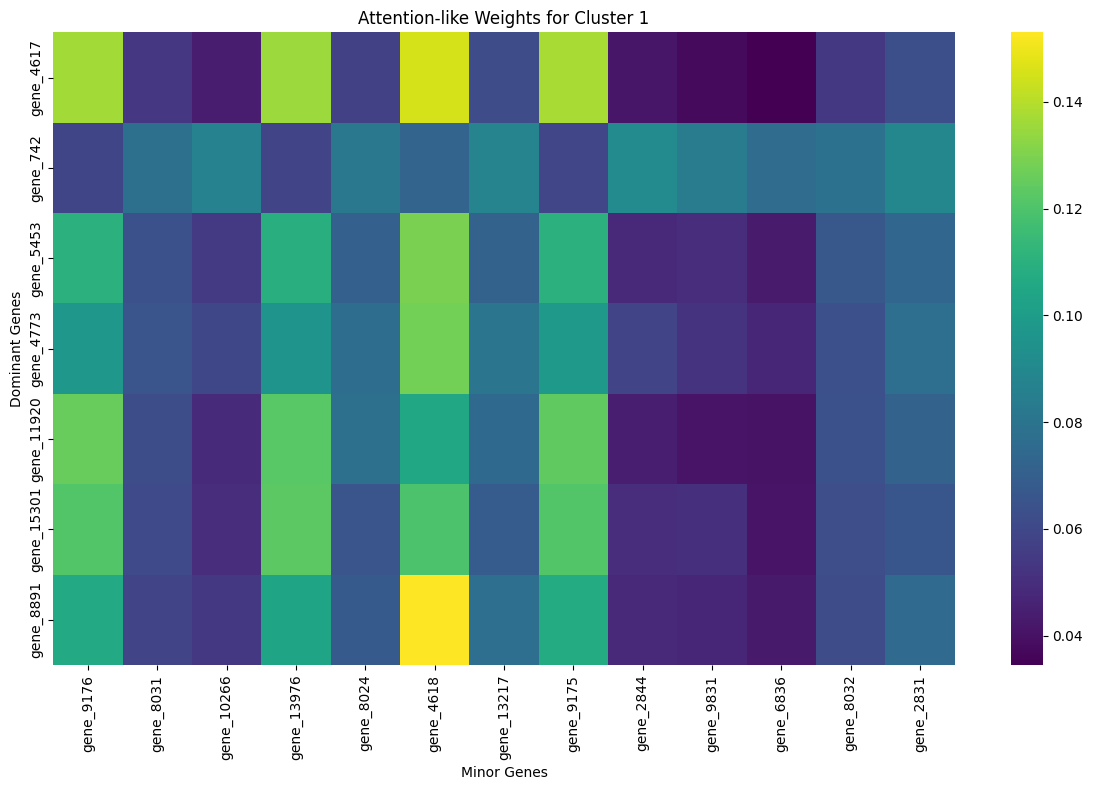

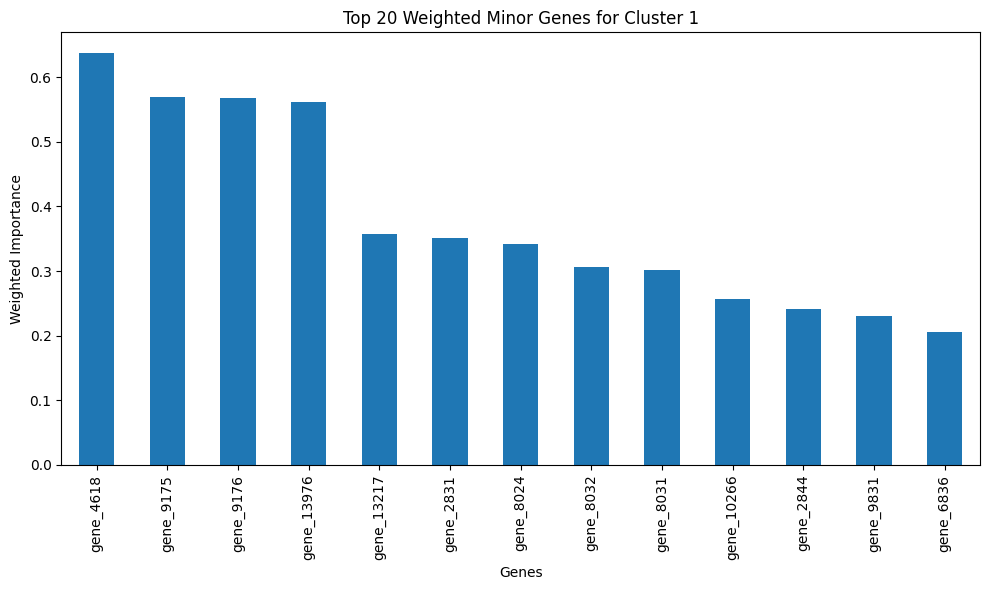


Analysis for Cluster 0
Top 10 most important minor genes based on attention-like weights:
gene_4618     0.014434
gene_7964     0.013575
gene_14089    0.012421
gene_4599     0.011675
gene_8027     0.011672
gene_3785     0.011523
gene_15589    0.011383
gene_10279    0.011364
gene_357      0.011099
gene_706      0.010918
dtype: float64


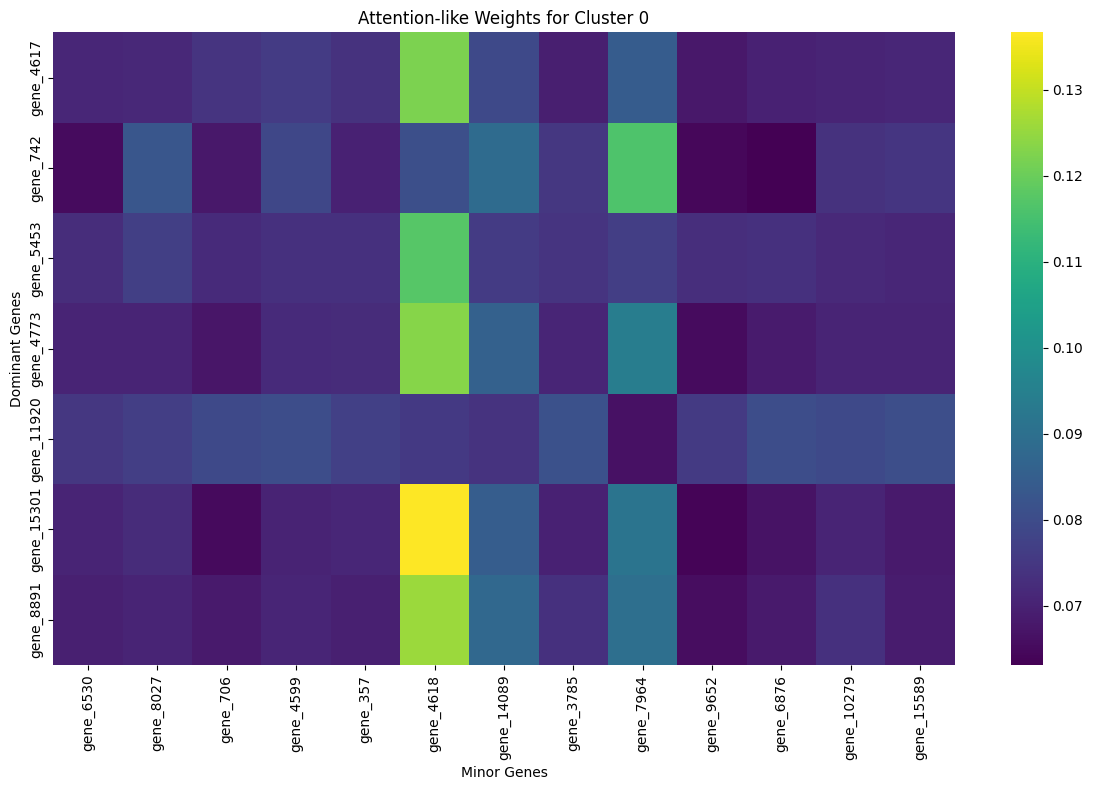

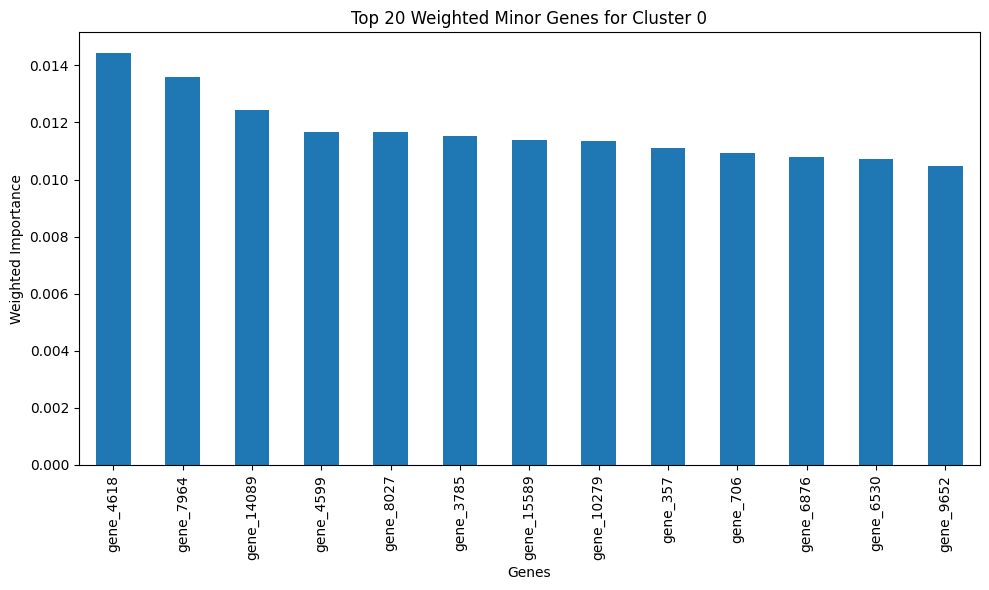


Analysis for Cluster 3
Top 10 most important minor genes based on attention-like weights:
gene_7965     0.103039
gene_3217     0.098200
gene_3921     0.097916
gene_16337    0.097735
gene_30       0.095941
gene_3461     0.090885
gene_628      0.083412
gene_1795     0.080317
gene_4618     0.073338
gene_3843     0.073199
dtype: float64


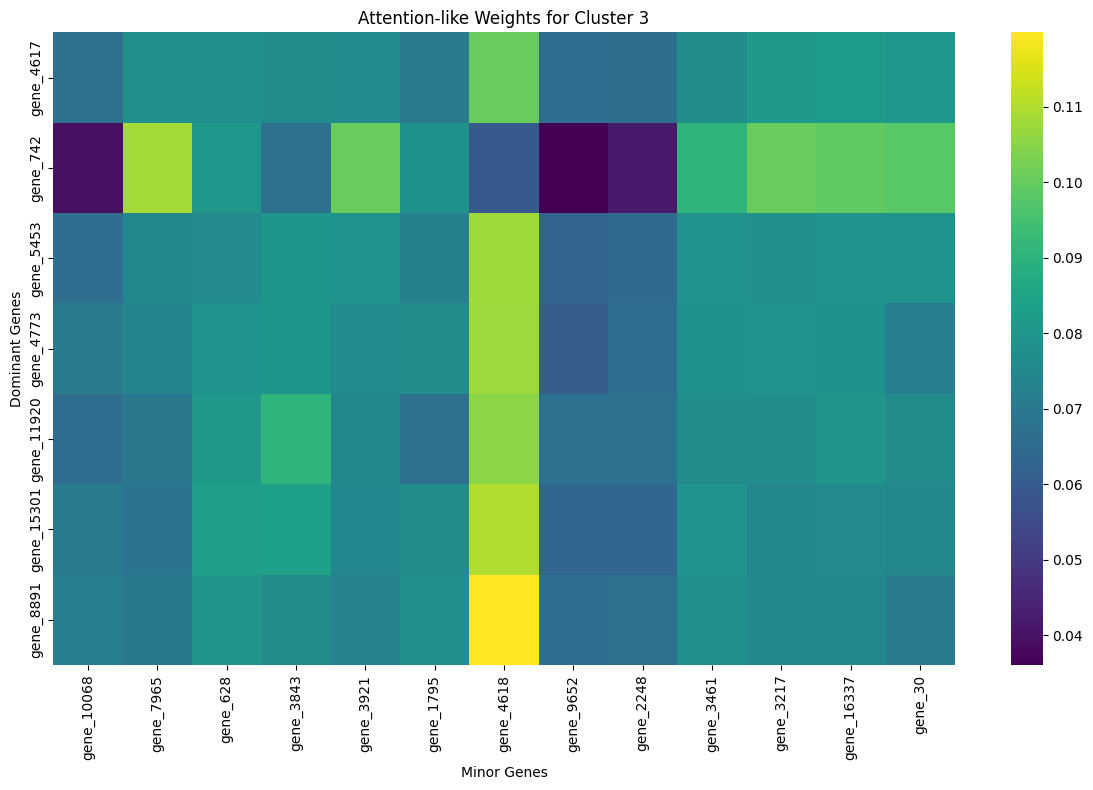

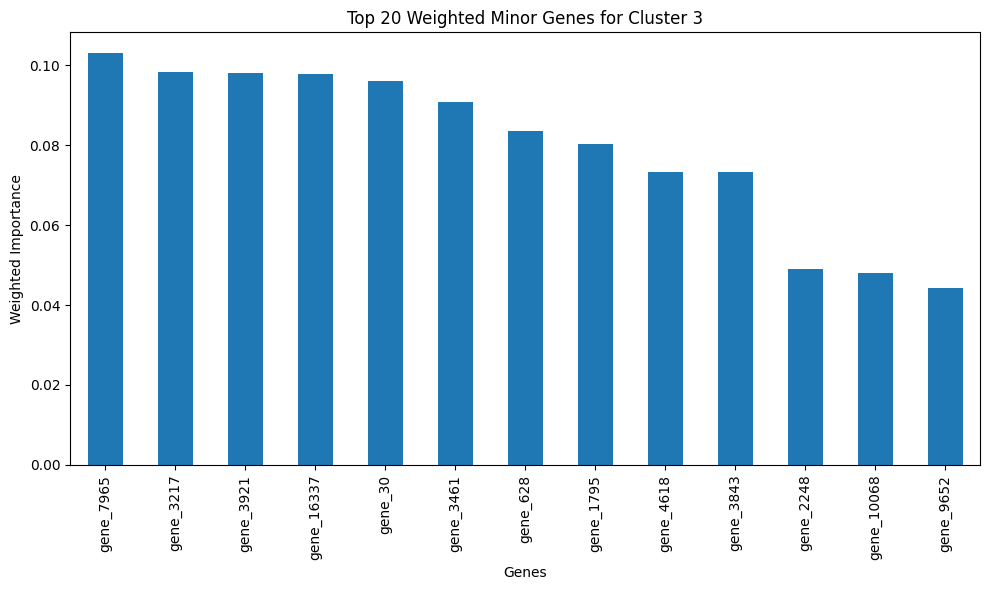


Analysis for Cluster 2
Top 10 most important minor genes based on attention-like weights:
gene_3217     0.349521
gene_3921     0.348176
gene_30       0.329458
gene_3461     0.328790
gene_16337    0.321615
gene_10068    0.312722
gene_1795     0.311784
gene_2248     0.303331
gene_7965     0.298814
gene_9652     0.298665
dtype: float64


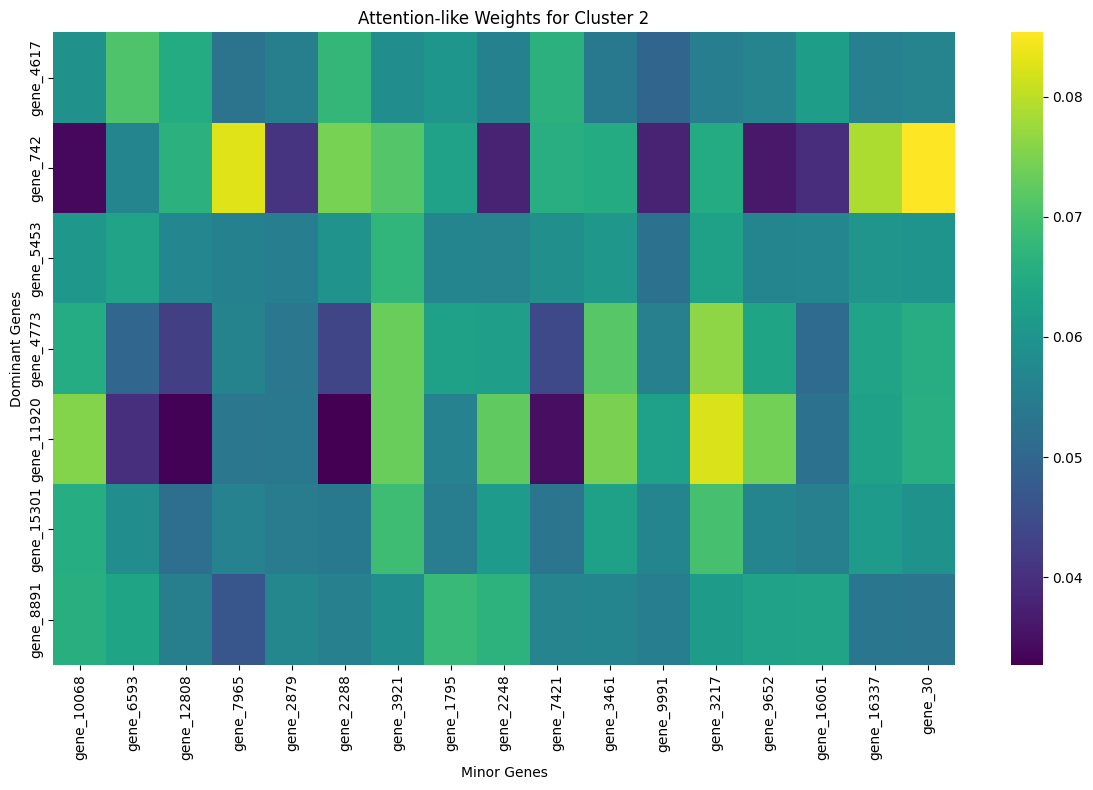

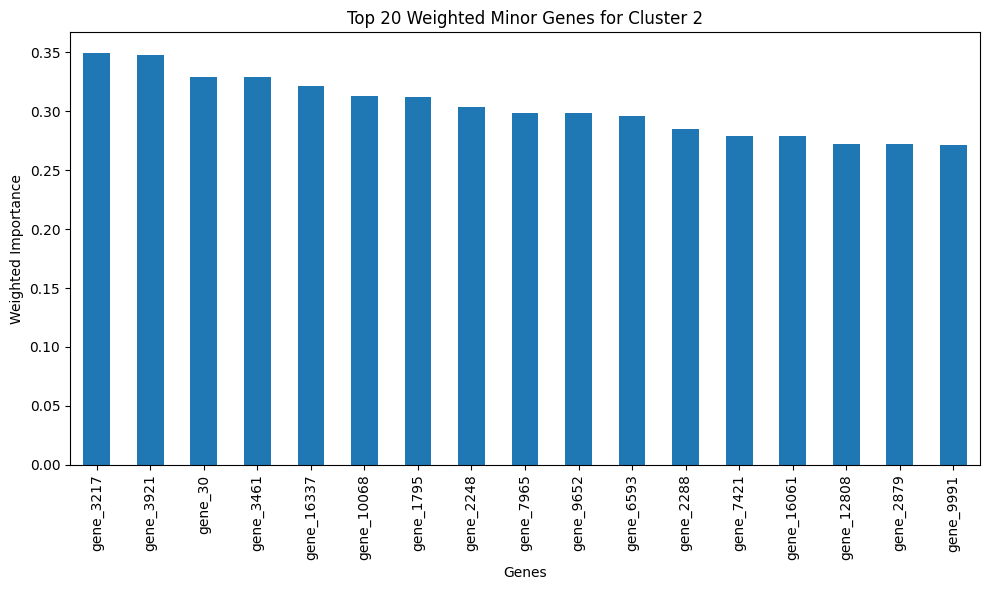

In [38]:
for cluster in df['cluster'].unique():
    print(f"\nAnalysis for Cluster {cluster}")
    
    dominant_genes = list(major_genes)
    minor_genes = minor_genes_by_cluster[cluster]
    
    # Compute similarity scores
    similarity_matrix = compute_similarity_scores(df, dominant_genes, minor_genes, cluster)
    
    # Compute attention-like weights
    attention_weights = compute_attention_weights(similarity_matrix)
    
    # Analyze weighted minor genes
    weighted_importance = analyze_weighted_genes(df, dominant_genes, minor_genes, attention_weights, cluster)
    
    print("Top 10 most important minor genes based on attention-like weights:")
    print(weighted_importance.head(10))
    
    # Visualize the attention weights
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_weights, cmap='viridis')
    plt.title(f"Attention-like Weights for Cluster {cluster}")
    plt.xlabel("Minor Genes")
    plt.ylabel("Dominant Genes")
    plt.tight_layout()
    plt.show()
    
    # Visualize the weighted importance of minor genes
    plt.figure(figsize=(10, 6))
    weighted_importance.head(20).plot(kind='bar')
    plt.title(f"Top 20 Weighted Minor Genes for Cluster {cluster}")
    plt.xlabel("Genes")
    plt.ylabel("Weighted Importance")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()